# DMT Creep Protocol: Viscosity Bifurcation and Delayed Yielding

## Learning Objectives

1. **Maxwell Elastic Jump**: Understand instantaneous elastic response γ_e(0) = σ₀/G in creep
2. **Viscosity Bifurcation**: Distinguish sub-yield (bounded strain) vs supra-yield (unbounded) regimes
3. **Delayed Yielding**: Observe thixotropic delayed flow onset near critical stress
4. **Real Data Fitting**: Fit biological mucus creep compliance data

## Prerequisites

- Understanding of creep compliance J(t) = γ(t)/σ₀
- Familiarity with DMT structural kinetics (λ parameter)
- Knowledge of Maxwell viscoelastic model

## Runtime

- NLSQ fitting: ~5-15 seconds
- Bayesian inference: ~2-5 minutes (1000 warmup + 2000 samples, 4 chains)
- Total: ~5-10 minutes

## Setup

In [1]:
# Google Colab setup
try:
    import google.colab
    IN_COLAB = True
    !pip install -q rheojax arviz
    import os
    os.environ['JAX_ENABLE_X64'] = '1'
except ImportError:
    IN_COLAB = False

In [2]:
# Core imports
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
from scipy.optimize import curve_fit

# JAX-safe imports
from rheojax.core.jax_config import safe_import_jax, verify_float64
jax, jnp = safe_import_jax()
verify_float64()

# RheoJAX imports
from rheojax.models import DMTLocal
from rheojax.core.parameters import Parameter, ParameterSet

# Bayesian imports
import arviz as az

# Plotting
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

print(f"JAX version: {jax.__version__}")
print(f"JAX devices: {jax.devices()}")
print(f"Float64 enabled: {jax.config.jax_enable_x64}")

JAX version: 0.8.2
JAX devices: [CpuDevice(id=0)]
Float64 enabled: True


## Theory: DMT Creep Protocol

### Creep Test

Apply constant stress σ₀ and measure strain γ(t) evolution:

**Creep compliance**: J(t) = γ(t) / σ₀

### Maxwell Variant Response

For DMT with Maxwell backbone (`include_elasticity=True`):

1. **Elastic jump** (instantaneous): γ_e(0) = σ₀ / G
2. **Viscous flow**: γ̇_v = σ₀ / η(λ) where η(λ) depends on structure
3. **Structure evolution**: dλ/dt = (1-λ)/t_eq - aλ|γ̇_v|^c / t_eq

### Viscosity Bifurcation

The exponential closure η = η_∞(η_0/η_∞)^λ creates two regimes:

- **Sub-yield** (σ₀ < σ_y): Structure rebuilds, viscosity increases, flow stops → bounded γ(t)
- **Supra-yield** (σ₀ > σ_y): Structure breaks down, viscosity decreases, continuous flow → unbounded γ(t)

### Physical Interpretation

- Near critical stress: **delayed yielding** due to slow structure evolution
- Biological relevance: mucus flow under gravity vs applied pressure
- Characteristic timescale: t_eq (structure equilibration time)

## Load Real Creep Data: Biological Mucus

In [3]:
# Load mucus creep compliance data
data_path = os.path.join("..", "data", "creep", "biological", "creep_mucus_data.csv")

if not os.path.exists(data_path):
    # Fallback to alternative path structures
    alt_paths = [
        "../data/creep/biological/creep_mucus_data.csv",
        "data/creep/biological/creep_mucus_data.csv",
        "examples/data/creep/biological/creep_mucus_data.csv"
    ]
    for path in alt_paths:
        if os.path.exists(path):
            data_path = path
            break
    else:
        raise FileNotFoundError(
            f"Creep data not found. Expected at: {data_path}\n"
            "Please ensure the data file exists or adjust the path."
        )

# Load data (tab-separated, with header)
raw = np.loadtxt(data_path, delimiter="\t", skiprows=1)
time_data = raw[:, 0]  # Time [s]
J_data = raw[:, 1]     # Creep compliance [1/Pa]

print(f"Loaded {len(time_data)} data points")
print(f"Time range: {time_data[0]:.2e} - {time_data[-1]:.2e} s")
print(f"Compliance range: {J_data[0]:.2e} - {J_data[-1]:.2e} 1/Pa")

Loaded 20 data points
Time range: 5.00e-01 - 1.00e+01 s
Compliance range: 9.84e-01 - 2.37e+00 1/Pa


### Data Inspection and Conversion

**Important**: The data represents creep compliance J(t) = γ(t) / σ₀, not strain directly.

To convert to strain: γ(t) = J(t) × σ₀

For fitting purposes, we assume σ₀ = 1 Pa, so numerically γ(t) ≈ J(t).

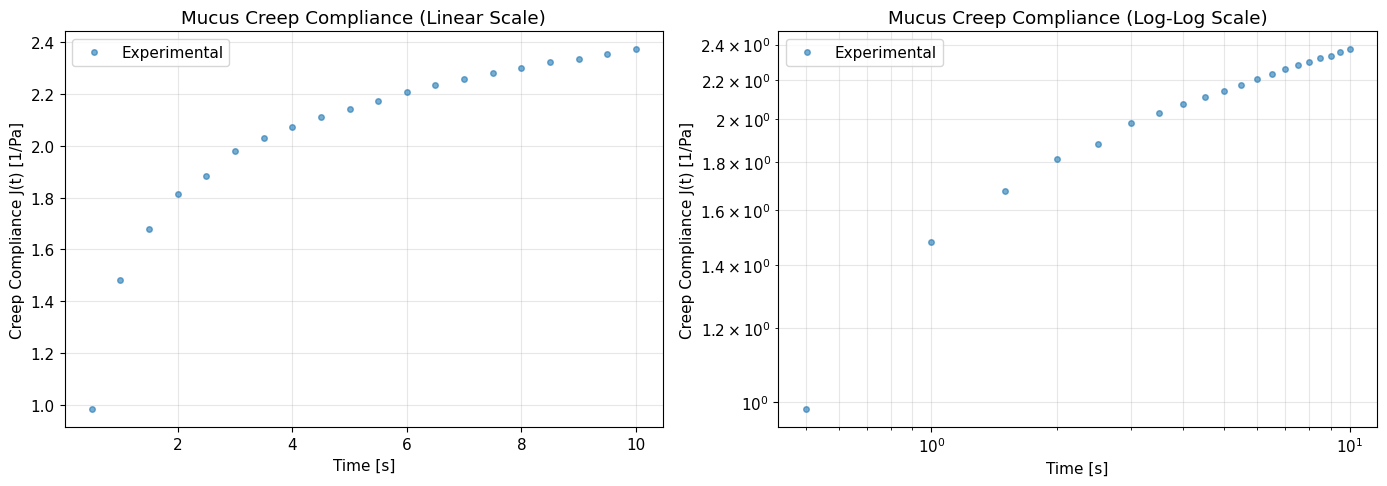


Assumed applied stress: σ₀ = 1.0 Pa
Strain range: 9.84e-01 - 2.37e+00


In [4]:
# Assume applied stress for conversion
sigma_0 = 1.0  # Pa (assumed - if σ₀=1, then γ=J)

# Convert compliance to strain
gamma_data = J_data * sigma_0

# Plot raw data
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Linear scale
axes[0].plot(time_data, J_data, 'o', markersize=4, alpha=0.6, label='Experimental')
axes[0].set_xlabel('Time [s]')
axes[0].set_ylabel('Creep Compliance J(t) [1/Pa]')
axes[0].set_title('Mucus Creep Compliance (Linear Scale)')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Log-log scale
axes[1].loglog(time_data, J_data, 'o', markersize=4, alpha=0.6, label='Experimental')
axes[1].set_xlabel('Time [s]')
axes[1].set_ylabel('Creep Compliance J(t) [1/Pa]')
axes[1].set_title('Mucus Creep Compliance (Log-Log Scale)')
axes[1].grid(True, alpha=0.3, which='both')
axes[1].legend()

plt.tight_layout()
display(fig)
plt.close(fig)

print(f"\nAssumed applied stress: σ₀ = {sigma_0} Pa")
print(f"Strain range: {gamma_data[0]:.2e} - {gamma_data[-1]:.2e}")

## NLSQ Fitting: Fast Parameter Estimation

We use NLSQ optimization to fit the DMT creep model to data.

**Strategy**:
1. Create wrapper function that calls `model.simulate_creep()`
2. Interpolate simulation output to match data time points
3. Use NLSQ for fast fitting (5-270x faster than scipy)

In [5]:
# Initialize model with Maxwell elasticity
model = DMTLocal(closure="exponential", include_elasticity=True)

# Create ParameterSet for fitting using DMT model parameter names
from rheojax.core.parameters import ParameterSet

params = ParameterSet()
params.add('eta_inf', value=1e2, bounds=(1e0, 1e6))      # Low-structure viscosity [Pa·s]
params.add('eta_0', value=1e5, bounds=(1e2, 1e8))        # High-structure viscosity [Pa·s]
params.add('t_eq', value=10.0, bounds=(0.1, 1e3))        # Equilibration time [s]
params.add('a', value=1.0, bounds=(0.1, 10.0))           # Structure breakdown rate
params.add('c', value=1.0, bounds=(0.5, 2.0))            # Shear-rate exponent
params.add('G0', value=100.0, bounds=(1.0, 1e4))         # Elastic modulus [Pa]
params.add('m_G', value=1.0, bounds=(0.1, 3.0))          # Structure exponent for G

print("Initial parameters:")
for name in params.keys():
    p = params[name]
    print(f"  {name}: {p.value:.2e} (bounds: {p.bounds})")

Initial parameters:
  eta_inf: 1.00e+02 (bounds: (1.0, 1000000.0))
  eta_0: 1.00e+05 (bounds: (100.0, 100000000.0))
  t_eq: 1.00e+01 (bounds: (0.1, 1000.0))
  a: 1.00e+00 (bounds: (0.1, 10.0))
  c: 1.00e+00 (bounds: (0.5, 2.0))
  G0: 1.00e+02 (bounds: (1.0, 10000.0))
  m_G: 1.00e+00 (bounds: (0.1, 3.0))


In [6]:
# Create scipy-compatible wrapper function
def dmt_creep_fn(t_data, eta_inf, eta_0, t_eq, a, c, G0, m_G):
    """
    Wrapper for DMT creep simulation using scipy-compatible signature.
    
    Args:
        t_data: Time points for evaluation
        eta_inf, eta_0, t_eq, a, c, G0, m_G: Model parameters
    
    Returns:
        Predicted strain values at t_data points
    """
    # Set model parameters
    model.parameters.set_value("eta_inf", float(eta_inf))
    model.parameters.set_value("eta_0", float(eta_0))
    model.parameters.set_value("t_eq", float(t_eq))
    model.parameters.set_value("a", float(a))
    model.parameters.set_value("c", float(c))
    model.parameters.set_value("G0", float(G0))
    model.parameters.set_value("m_G", float(m_G))
    
    # Simulate creep (returns time, strain, strain_rate, lambda)
    t_end = float(np.max(t_data)) * 1.2  # Simulate slightly beyond last data point
    dt = t_end / 500  # Use 500 points
    t_sim, gamma_sim, gamma_dot_sim, lambda_sim = model.simulate_creep(
        sigma_0=sigma_0,
        t_end=t_end,
        dt=dt
    )
    
    # Interpolate to data time points
    gamma_pred = np.interp(t_data, np.array(t_sim), np.array(gamma_sim))
    
    return gamma_pred

print("Created scipy-compatible wrapper function for DMT creep simulation")

Created scipy-compatible wrapper function for DMT creep simulation


In [7]:
# Perform optimization using scipy.optimize.curve_fit
print("Starting optimization with scipy.optimize.curve_fit...")

# Helper function for computing fit quality
def compute_fit_quality(y_true, y_pred):
    """Compute R² and RMSE."""
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    residuals = y_true - y_pred
    if y_true.ndim > 1:
        residuals = residuals.ravel()
        y_true = y_true.ravel()
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    r2 = 1.0 - ss_res / ss_tot if ss_tot > 0 else 0.0
    rmse = np.sqrt(np.mean(residuals**2))
    return {"R2": r2, "RMSE": rmse}

# Initial guesses - eta_inf must be < 100 (model constraint)
p0 = [10.0, 1e5, 10.0, 1.0, 1.0, 100.0, 1.0]

# Bounds (lower, upper) - must match DMT model constraints
# eta_inf: (0.001, 100.0), eta_0: (100.0, 1e8), t_eq: (0.1, 10000.0)
# a: (0.001, 100.0), c: (0.1, 2.0), G0: (1.0, 1e6), m_G: (0.5, 2.0)
bounds = (
    [0.001, 1e2, 0.1, 0.1, 0.5, 1.0, 0.5],    # lower
    [99.9, 1e8, 1e4, 10.0, 2.0, 1e4, 2.0]     # upper (eta_inf < 100 to avoid bound violation)
)

popt, pcov = curve_fit(
    dmt_creep_fn,
    time_data,
    gamma_data,
    p0=p0,
    bounds=bounds,
    maxfev=5000
)

# Parameter names
param_names = ['eta_inf', 'eta_0', 't_eq', 'a', 'c', 'G0', 'm_G']

# Compute predictions and metrics
gamma_pred = dmt_creep_fn(time_data, *popt)
metrics = compute_fit_quality(gamma_data, gamma_pred)

print(f"\nOptimization converged successfully")
print(f"R² score: {metrics['R2']:.6f}")
print(f"RMSE: {metrics['RMSE']:.6e}")
print(f"\nFitted parameters:")

fitted_params = {}
for name, value in zip(param_names, popt):
    fitted_params[name] = float(value)
    print(f"  {name}: {value:.6e}")

# Update model with fitted parameters
for name, value in fitted_params.items():
    model.parameters.set_value(name, value)

Starting optimization with scipy.optimize.curve_fit...



Optimization converged successfully
R² score: -2.248304
RMSE: 6.097885e-01

Fitted parameters:
  eta_inf: 2.068871e-02
  eta_0: 2.545886e+04
  t_eq: 2.027957e-01
  a: 9.996468e+00
  c: 5.000007e-01
  G0: 1.000628e+00
  m_G: 1.999718e+00


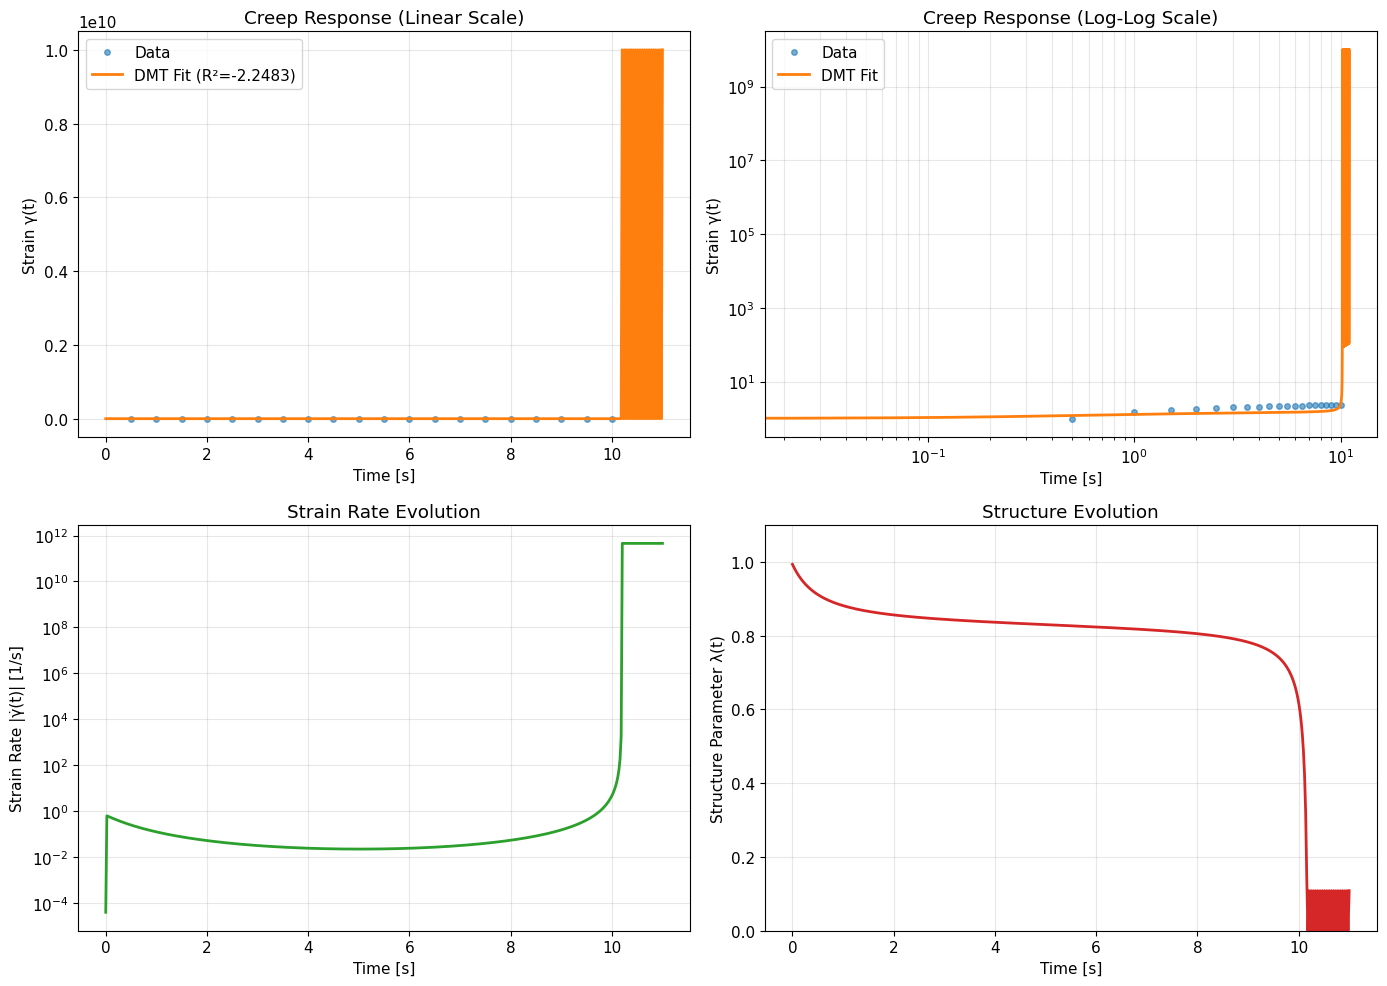

In [8]:
# Generate fitted curve
t_end_fit = time_data[-1] * 1.1
dt_fit = t_end_fit / 500
t_fit, gamma_fit, gamma_dot_fit, lambda_fit = model.simulate_creep(
    sigma_0=sigma_0,
    t_end=t_end_fit,
    dt=dt_fit
)

# Plot fit vs data
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Strain - Linear scale
axes[0, 0].plot(time_data, gamma_data, 'o', markersize=4, alpha=0.6, label='Data')
axes[0, 0].plot(t_fit, gamma_fit, '-', linewidth=2, label=f'DMT Fit (R²={metrics["R2"]:.4f})')
axes[0, 0].set_xlabel('Time [s]')
axes[0, 0].set_ylabel('Strain γ(t)')
axes[0, 0].set_title('Creep Response (Linear Scale)')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()

# Strain - Log-log scale
axes[0, 1].loglog(time_data, gamma_data, 'o', markersize=4, alpha=0.6, label='Data')
axes[0, 1].loglog(t_fit, gamma_fit, '-', linewidth=2, label='DMT Fit')
axes[0, 1].set_xlabel('Time [s]')
axes[0, 1].set_ylabel('Strain γ(t)')
axes[0, 1].set_title('Creep Response (Log-Log Scale)')
axes[0, 1].grid(True, alpha=0.3, which='both')
axes[0, 1].legend()

# Strain rate evolution
axes[1, 0].semilogy(t_fit, jnp.abs(gamma_dot_fit), '-', linewidth=2, color='C2')
axes[1, 0].set_xlabel('Time [s]')
axes[1, 0].set_ylabel('Strain Rate |γ̇(t)| [1/s]')
axes[1, 0].set_title('Strain Rate Evolution')
axes[1, 0].grid(True, alpha=0.3)

# Structure parameter evolution
axes[1, 1].plot(t_fit, lambda_fit, '-', linewidth=2, color='C3')
axes[1, 1].set_xlabel('Time [s]')
axes[1, 1].set_ylabel('Structure Parameter λ(t)')
axes[1, 1].set_title('Structure Evolution')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_ylim([0, 1.1])

plt.tight_layout()
display(fig)
plt.close(fig)

## Bayesian Inference: Uncertainty Quantification

Use NUTS sampling to:
1. Quantify parameter uncertainty
2. Check parameter correlations
3. Generate posterior predictive distributions

In [9]:
# Set model attributes for Bayesian inference
model._sigma_applied = sigma_0
model._creep_lam_init = 1.0  # Assume fully structured initial state

print("Starting Bayesian inference (NUTS)...")
print("This will take 2-5 minutes with 4 chains...")

# Bayesian inference with NLSQ warm-start
posterior_result = model.fit_bayesian(
    time_data,
    gamma_data,
    test_mode='creep',
    num_warmup=1000,
    num_samples=2000,
    num_chains=4,
    seed=42
)

print("\nBayesian inference complete!")

Starting Bayesian inference (NUTS)...
This will take 2-5 minutes with 4 chains...


  0%|          | 0/3000 [00:00<?, ?it/s]

warmup:   0%|          | 1/3000 [00:02<1:46:17,  2.13s/it]

warmup:   0%|          | 2/3000 [00:04<1:52:40,  2.25s/it]

warmup:   2%|▏         | 46/3000 [00:04<03:02, 16.23it/s] 

warmup:   4%|▎         | 105/3000 [00:04<01:05, 44.17it/s]

warmup:   5%|▍         | 140/3000 [00:05<00:59, 48.13it/s]

warmup:   6%|▌         | 165/3000 [00:06<01:05, 43.22it/s]

warmup:   6%|▌         | 183/3000 [00:06<01:12, 38.80it/s]

warmup:   7%|▋         | 196/3000 [00:07<01:30, 30.93it/s]

warmup:   7%|▋         | 206/3000 [00:08<01:45, 26.58it/s]

warmup:   7%|▋         | 213/3000 [00:08<01:53, 24.50it/s]

warmup:   7%|▋         | 219/3000 [00:08<01:58, 23.39it/s]

warmup:   7%|▋         | 224/3000 [00:09<02:06, 22.02it/s]

warmup:   8%|▊         | 228/3000 [00:09<02:10, 21.31it/s]

warmup:   8%|▊         | 231/3000 [00:09<02:15, 20.37it/s]

warmup:   8%|▊         | 234/3000 [00:09<02:26, 18.92it/s]

warmup:   8%|▊         | 237/3000 [00:09<02:34, 17.85it/s]

warmup:   8%|▊         | 239/3000 [00:10<02:50, 16.21it/s]

warmup:   8%|▊         | 241/3000 [00:10<02:50, 16.23it/s]

warmup:   8%|▊         | 243/3000 [00:10<02:50, 16.20it/s]

warmup:   8%|▊         | 245/3000 [00:10<02:47, 16.45it/s]

warmup:   8%|▊         | 247/3000 [00:10<03:30, 13.11it/s]

warmup:   8%|▊         | 249/3000 [00:10<03:16, 14.01it/s]

warmup:   8%|▊         | 251/3000 [00:11<03:05, 14.82it/s]

warmup:   9%|▊         | 257/3000 [00:11<01:52, 24.28it/s]

warmup:   9%|▊         | 260/3000 [00:11<02:10, 21.01it/s]

warmup:   9%|▉         | 263/3000 [00:11<02:23, 19.05it/s]

warmup:   9%|▉         | 266/3000 [00:11<02:28, 18.41it/s]

warmup:   9%|▉         | 270/3000 [00:11<02:09, 21.03it/s]

warmup:   9%|▉         | 273/3000 [00:11<02:15, 20.18it/s]

warmup:   9%|▉         | 276/3000 [00:12<02:27, 18.43it/s]

warmup:   9%|▉         | 278/3000 [00:12<02:47, 16.27it/s]

warmup:   9%|▉         | 280/3000 [00:12<02:45, 16.44it/s]

warmup:   9%|▉         | 282/3000 [00:12<02:57, 15.27it/s]

warmup:   9%|▉         | 284/3000 [00:12<02:49, 16.05it/s]

warmup:  10%|▉         | 286/3000 [00:12<02:45, 16.43it/s]

warmup:  10%|▉         | 288/3000 [00:12<02:45, 16.35it/s]

warmup:  10%|▉         | 290/3000 [00:13<02:43, 16.57it/s]

warmup:  10%|▉         | 292/3000 [00:13<02:47, 16.13it/s]

warmup:  10%|▉         | 294/3000 [00:13<02:57, 15.26it/s]

warmup:  10%|▉         | 296/3000 [00:13<02:52, 15.72it/s]

warmup:  10%|▉         | 298/3000 [00:13<03:04, 14.62it/s]

warmup:  10%|█         | 300/3000 [00:13<02:51, 15.77it/s]

warmup:  10%|█         | 302/3000 [00:13<02:49, 15.93it/s]

warmup:  10%|█         | 304/3000 [00:14<02:53, 15.57it/s]

warmup:  10%|█         | 306/3000 [00:14<03:04, 14.57it/s]

warmup:  10%|█         | 308/3000 [00:14<03:01, 14.85it/s]

warmup:  10%|█         | 310/3000 [00:14<02:47, 16.03it/s]

warmup:  10%|█         | 312/3000 [00:14<02:40, 16.75it/s]

warmup:  10%|█         | 314/3000 [00:14<02:58, 15.03it/s]

warmup:  11%|█         | 316/3000 [00:14<02:52, 15.55it/s]

warmup:  11%|█         | 318/3000 [00:14<02:42, 16.46it/s]

warmup:  11%|█         | 320/3000 [00:15<02:37, 17.06it/s]

warmup:  11%|█         | 322/3000 [00:15<02:39, 16.76it/s]

warmup:  11%|█         | 324/3000 [00:15<02:36, 17.14it/s]

warmup:  11%|█         | 326/3000 [00:15<02:35, 17.21it/s]

warmup:  11%|█         | 328/3000 [00:15<02:36, 17.05it/s]

warmup:  11%|█         | 330/3000 [00:15<02:50, 15.70it/s]

warmup:  11%|█         | 332/3000 [00:15<03:02, 14.59it/s]

warmup:  11%|█         | 334/3000 [00:15<02:49, 15.69it/s]

warmup:  11%|█         | 336/3000 [00:16<02:49, 15.73it/s]

warmup:  11%|█▏        | 338/3000 [00:16<02:41, 16.51it/s]

warmup:  11%|█▏        | 340/3000 [00:16<02:42, 16.34it/s]

warmup:  11%|█▏        | 342/3000 [00:16<02:55, 15.17it/s]

warmup:  11%|█▏        | 344/3000 [00:16<02:49, 15.68it/s]

warmup:  12%|█▏        | 346/3000 [00:16<02:55, 15.12it/s]

warmup:  12%|█▏        | 348/3000 [00:16<02:44, 16.13it/s]

warmup:  12%|█▏        | 350/3000 [00:16<02:36, 16.98it/s]

warmup:  12%|█▏        | 352/3000 [00:17<02:46, 15.90it/s]

warmup:  12%|█▏        | 354/3000 [00:17<02:36, 16.86it/s]

warmup:  12%|█▏        | 356/3000 [00:17<02:42, 16.24it/s]

warmup:  12%|█▏        | 358/3000 [00:17<02:59, 14.69it/s]

warmup:  12%|█▏        | 360/3000 [00:17<02:48, 15.63it/s]

warmup:  12%|█▏        | 362/3000 [00:17<02:42, 16.21it/s]

warmup:  12%|█▏        | 364/3000 [00:17<02:37, 16.70it/s]

warmup:  12%|█▏        | 366/3000 [00:17<02:40, 16.37it/s]

warmup:  12%|█▏        | 368/3000 [00:18<02:47, 15.72it/s]

warmup:  12%|█▏        | 370/3000 [00:18<02:40, 16.43it/s]

warmup:  12%|█▏        | 372/3000 [00:18<02:35, 16.90it/s]

warmup:  12%|█▏        | 374/3000 [00:18<02:44, 15.99it/s]

warmup:  13%|█▎        | 376/3000 [00:18<02:43, 16.09it/s]

warmup:  13%|█▎        | 378/3000 [00:18<02:42, 16.16it/s]

warmup:  13%|█▎        | 380/3000 [00:18<02:42, 16.13it/s]

warmup:  13%|█▎        | 382/3000 [00:18<02:42, 16.14it/s]

warmup:  13%|█▎        | 384/3000 [00:18<02:33, 17.03it/s]

warmup:  13%|█▎        | 386/3000 [00:19<02:45, 15.78it/s]

warmup:  13%|█▎        | 388/3000 [00:19<02:42, 16.04it/s]

warmup:  13%|█▎        | 390/3000 [00:19<02:43, 16.00it/s]

warmup:  13%|█▎        | 392/3000 [00:19<02:57, 14.70it/s]

warmup:  13%|█▎        | 394/3000 [00:19<03:02, 14.31it/s]

warmup:  13%|█▎        | 396/3000 [00:19<02:56, 14.75it/s]

warmup:  13%|█▎        | 398/3000 [00:19<02:47, 15.56it/s]

warmup:  13%|█▎        | 400/3000 [00:20<02:44, 15.79it/s]

warmup:  13%|█▎        | 402/3000 [00:20<02:38, 16.35it/s]

warmup:  13%|█▎        | 404/3000 [00:20<02:34, 16.83it/s]

warmup:  14%|█▎        | 406/3000 [00:20<02:39, 16.31it/s]

warmup:  14%|█▎        | 409/3000 [00:20<02:27, 17.62it/s]

warmup:  14%|█▎        | 411/3000 [00:20<02:28, 17.41it/s]

warmup:  14%|█▍        | 413/3000 [00:20<02:30, 17.15it/s]

warmup:  14%|█▍        | 415/3000 [00:20<02:37, 16.40it/s]

warmup:  14%|█▍        | 417/3000 [00:21<02:36, 16.55it/s]

warmup:  14%|█▍        | 419/3000 [00:21<02:33, 16.87it/s]

warmup:  14%|█▍        | 421/3000 [00:21<02:34, 16.70it/s]

warmup:  14%|█▍        | 423/3000 [00:21<02:37, 16.37it/s]

warmup:  14%|█▍        | 425/3000 [00:21<02:30, 17.17it/s]

warmup:  14%|█▍        | 427/3000 [00:21<02:28, 17.35it/s]

warmup:  14%|█▍        | 429/3000 [00:21<02:40, 16.03it/s]

warmup:  14%|█▍        | 431/3000 [00:21<02:35, 16.50it/s]

warmup:  14%|█▍        | 433/3000 [00:22<02:41, 15.89it/s]

warmup:  14%|█▍        | 435/3000 [00:22<02:42, 15.83it/s]

warmup:  15%|█▍        | 437/3000 [00:22<02:35, 16.52it/s]

warmup:  15%|█▍        | 439/3000 [00:22<03:02, 14.07it/s]

warmup:  15%|█▍        | 441/3000 [00:22<03:08, 13.56it/s]

warmup:  15%|█▍        | 443/3000 [00:22<03:01, 14.09it/s]

warmup:  15%|█▍        | 445/3000 [00:22<02:50, 14.97it/s]

warmup:  15%|█▍        | 447/3000 [00:22<02:38, 16.14it/s]

warmup:  15%|█▍        | 449/3000 [00:23<03:10, 13.41it/s]

warmup:  15%|█▌        | 451/3000 [00:23<03:01, 14.01it/s]

warmup:  15%|█▌        | 454/3000 [00:23<02:36, 16.31it/s]

warmup:  15%|█▌        | 456/3000 [00:23<02:30, 16.91it/s]

warmup:  15%|█▌        | 458/3000 [00:23<02:30, 16.93it/s]

warmup:  15%|█▌        | 460/3000 [00:23<02:32, 16.68it/s]

warmup:  15%|█▌        | 462/3000 [00:23<02:36, 16.21it/s]

warmup:  15%|█▌        | 464/3000 [00:24<02:35, 16.29it/s]

warmup:  16%|█▌        | 466/3000 [00:24<02:39, 15.87it/s]

warmup:  16%|█▌        | 468/3000 [00:24<02:39, 15.90it/s]

warmup:  16%|█▌        | 470/3000 [00:24<02:38, 15.95it/s]

warmup:  16%|█▌        | 472/3000 [00:24<02:30, 16.84it/s]

warmup:  16%|█▌        | 474/3000 [00:24<02:34, 16.31it/s]

warmup:  16%|█▌        | 477/3000 [00:24<02:24, 17.47it/s]

warmup:  16%|█▌        | 480/3000 [00:24<02:16, 18.44it/s]

warmup:  16%|█▌        | 482/3000 [00:25<02:18, 18.15it/s]

warmup:  16%|█▌        | 484/3000 [00:25<02:24, 17.39it/s]

warmup:  16%|█▌        | 486/3000 [00:25<02:27, 17.05it/s]

warmup:  16%|█▋        | 488/3000 [00:25<02:26, 17.11it/s]

warmup:  16%|█▋        | 490/3000 [00:25<02:54, 14.40it/s]

warmup:  16%|█▋        | 492/3000 [00:25<02:42, 15.48it/s]

warmup:  16%|█▋        | 494/3000 [00:25<02:41, 15.56it/s]

warmup:  17%|█▋        | 496/3000 [00:25<02:37, 15.93it/s]

warmup:  17%|█▋        | 498/3000 [00:26<02:50, 14.72it/s]

warmup:  17%|█▋        | 500/3000 [00:26<02:38, 15.75it/s]

warmup:  17%|█▋        | 502/3000 [00:26<02:31, 16.45it/s]

warmup:  17%|█▋        | 505/3000 [00:26<02:26, 16.99it/s]

warmup:  17%|█▋        | 507/3000 [00:26<02:22, 17.52it/s]

warmup:  17%|█▋        | 509/3000 [00:26<02:21, 17.65it/s]

warmup:  17%|█▋        | 511/3000 [00:26<02:19, 17.83it/s]

warmup:  17%|█▋        | 513/3000 [00:26<02:17, 18.13it/s]

warmup:  17%|█▋        | 515/3000 [00:27<02:13, 18.56it/s]

warmup:  17%|█▋        | 517/3000 [00:27<02:15, 18.30it/s]

warmup:  17%|█▋        | 519/3000 [00:27<02:21, 17.59it/s]

warmup:  17%|█▋        | 521/3000 [00:27<02:26, 16.86it/s]

warmup:  17%|█▋        | 523/3000 [00:27<02:32, 16.28it/s]

warmup:  18%|█▊        | 525/3000 [00:27<02:24, 17.11it/s]

warmup:  18%|█▊        | 527/3000 [00:27<02:20, 17.57it/s]

warmup:  18%|█▊        | 529/3000 [00:27<02:21, 17.52it/s]

warmup:  18%|█▊        | 531/3000 [00:27<02:20, 17.54it/s]

warmup:  18%|█▊        | 534/3000 [00:28<02:12, 18.59it/s]

warmup:  18%|█▊        | 536/3000 [00:28<02:12, 18.62it/s]

warmup:  18%|█▊        | 538/3000 [00:28<02:13, 18.49it/s]

warmup:  18%|█▊        | 540/3000 [00:28<02:12, 18.58it/s]

warmup:  18%|█▊        | 542/3000 [00:28<02:48, 14.56it/s]

warmup:  18%|█▊        | 544/3000 [00:28<02:55, 14.00it/s]

warmup:  18%|█▊        | 546/3000 [00:28<02:42, 15.06it/s]

warmup:  18%|█▊        | 548/3000 [00:29<02:35, 15.81it/s]

warmup:  18%|█▊        | 550/3000 [00:29<02:37, 15.59it/s]

warmup:  18%|█▊        | 552/3000 [00:29<02:37, 15.58it/s]

warmup:  18%|█▊        | 554/3000 [00:29<02:27, 16.54it/s]

warmup:  19%|█▊        | 556/3000 [00:29<02:34, 15.79it/s]

warmup:  19%|█▊        | 558/3000 [00:29<02:33, 15.91it/s]

warmup:  19%|█▊        | 560/3000 [00:29<02:28, 16.41it/s]

warmup:  19%|█▊        | 562/3000 [00:29<02:22, 17.16it/s]

warmup:  19%|█▉        | 564/3000 [00:30<02:20, 17.38it/s]

warmup:  19%|█▉        | 566/3000 [00:30<02:23, 16.93it/s]

warmup:  19%|█▉        | 568/3000 [00:30<02:22, 17.03it/s]

warmup:  19%|█▉        | 570/3000 [00:30<02:24, 16.86it/s]

warmup:  19%|█▉        | 572/3000 [00:30<02:35, 15.64it/s]

warmup:  19%|█▉        | 574/3000 [00:30<02:39, 15.17it/s]

warmup:  19%|█▉        | 576/3000 [00:30<02:48, 14.40it/s]

warmup:  19%|█▉        | 578/3000 [00:30<02:42, 14.91it/s]

warmup:  19%|█▉        | 580/3000 [00:31<02:39, 15.19it/s]

warmup:  19%|█▉        | 582/3000 [00:31<02:31, 16.01it/s]

warmup:  19%|█▉        | 584/3000 [00:31<02:22, 16.94it/s]

warmup:  20%|█▉        | 586/3000 [00:31<02:33, 15.77it/s]

warmup:  20%|█▉        | 588/3000 [00:31<02:34, 15.63it/s]

warmup:  20%|█▉        | 590/3000 [00:31<02:41, 14.95it/s]

warmup:  20%|█▉        | 592/3000 [00:31<02:35, 15.46it/s]

warmup:  20%|█▉        | 595/3000 [00:31<02:20, 17.12it/s]

warmup:  20%|█▉        | 597/3000 [00:32<02:20, 17.10it/s]

warmup:  20%|█▉        | 599/3000 [00:32<02:21, 17.01it/s]

warmup:  20%|██        | 601/3000 [00:32<02:18, 17.36it/s]

warmup:  20%|██        | 603/3000 [00:32<02:20, 17.04it/s]

warmup:  20%|██        | 605/3000 [00:32<02:21, 16.89it/s]

warmup:  20%|██        | 607/3000 [00:32<02:25, 16.46it/s]

warmup:  20%|██        | 609/3000 [00:32<02:26, 16.30it/s]

warmup:  20%|██        | 611/3000 [00:32<02:22, 16.71it/s]

warmup:  20%|██        | 613/3000 [00:33<02:20, 17.02it/s]

warmup:  20%|██        | 615/3000 [00:33<02:19, 17.06it/s]

warmup:  21%|██        | 617/3000 [00:33<02:18, 17.21it/s]

warmup:  21%|██        | 619/3000 [00:33<02:20, 16.99it/s]

warmup:  21%|██        | 621/3000 [00:33<02:28, 16.00it/s]

warmup:  21%|██        | 623/3000 [00:33<02:25, 16.38it/s]

warmup:  21%|██        | 625/3000 [00:33<02:20, 16.90it/s]

warmup:  21%|██        | 627/3000 [00:33<02:15, 17.56it/s]

warmup:  21%|██        | 629/3000 [00:33<02:11, 18.02it/s]

warmup:  21%|██        | 631/3000 [00:34<02:11, 18.02it/s]

warmup:  21%|██        | 633/3000 [00:34<02:15, 17.42it/s]

warmup:  21%|██        | 635/3000 [00:34<02:13, 17.71it/s]

warmup:  21%|██        | 637/3000 [00:34<02:11, 17.95it/s]

warmup:  21%|██▏       | 639/3000 [00:34<02:20, 16.86it/s]

warmup:  21%|██▏       | 641/3000 [00:34<02:44, 14.36it/s]

warmup:  21%|██▏       | 643/3000 [00:34<02:35, 15.20it/s]

warmup:  22%|██▏       | 645/3000 [00:34<02:26, 16.12it/s]

warmup:  22%|██▏       | 647/3000 [00:35<02:17, 17.12it/s]

warmup:  22%|██▏       | 649/3000 [00:35<02:13, 17.64it/s]

warmup:  22%|██▏       | 652/3000 [00:35<02:09, 18.16it/s]

warmup:  22%|██▏       | 654/3000 [00:35<02:13, 17.57it/s]

warmup:  22%|██▏       | 656/3000 [00:35<02:28, 15.77it/s]

warmup:  22%|██▏       | 658/3000 [00:35<02:38, 14.75it/s]

warmup:  22%|██▏       | 660/3000 [00:35<02:37, 14.86it/s]

warmup:  22%|██▏       | 662/3000 [00:36<02:32, 15.33it/s]

warmup:  22%|██▏       | 664/3000 [00:36<02:23, 16.33it/s]

warmup:  22%|██▏       | 666/3000 [00:36<02:21, 16.53it/s]

warmup:  22%|██▏       | 668/3000 [00:36<02:19, 16.69it/s]

warmup:  22%|██▏       | 670/3000 [00:36<02:19, 16.74it/s]

warmup:  22%|██▏       | 672/3000 [00:36<02:28, 15.69it/s]

warmup:  22%|██▏       | 674/3000 [00:36<02:26, 15.87it/s]

warmup:  23%|██▎       | 676/3000 [00:36<02:23, 16.18it/s]

warmup:  23%|██▎       | 678/3000 [00:36<02:16, 16.95it/s]

warmup:  23%|██▎       | 680/3000 [00:37<02:15, 17.08it/s]

warmup:  23%|██▎       | 682/3000 [00:37<02:18, 16.75it/s]

warmup:  23%|██▎       | 684/3000 [00:37<02:16, 16.96it/s]

warmup:  23%|██▎       | 686/3000 [00:37<02:14, 17.19it/s]

warmup:  23%|██▎       | 688/3000 [00:37<02:11, 17.62it/s]

warmup:  23%|██▎       | 690/3000 [00:37<02:48, 13.75it/s]

warmup:  23%|██▎       | 692/3000 [00:37<02:36, 14.74it/s]

warmup:  23%|██▎       | 694/3000 [00:37<02:25, 15.86it/s]

warmup:  23%|██▎       | 696/3000 [00:38<02:22, 16.17it/s]

warmup:  23%|██▎       | 698/3000 [00:38<02:17, 16.77it/s]

warmup:  23%|██▎       | 700/3000 [00:38<02:18, 16.63it/s]

warmup:  23%|██▎       | 702/3000 [00:38<02:13, 17.27it/s]

warmup:  23%|██▎       | 704/3000 [00:38<02:09, 17.77it/s]

warmup:  24%|██▎       | 706/3000 [00:38<02:14, 17.10it/s]

warmup:  24%|██▎       | 708/3000 [00:38<02:26, 15.65it/s]

warmup:  24%|██▎       | 710/3000 [00:38<02:23, 15.94it/s]

warmup:  24%|██▎       | 712/3000 [00:39<02:18, 16.52it/s]

warmup:  24%|██▍       | 714/3000 [00:39<02:11, 17.34it/s]

warmup:  24%|██▍       | 716/3000 [00:39<02:09, 17.69it/s]

warmup:  24%|██▍       | 718/3000 [00:39<02:11, 17.34it/s]

warmup:  24%|██▍       | 720/3000 [00:39<02:09, 17.66it/s]

warmup:  24%|██▍       | 722/3000 [00:39<02:14, 16.88it/s]

warmup:  24%|██▍       | 724/3000 [00:39<02:18, 16.44it/s]

warmup:  24%|██▍       | 726/3000 [00:39<02:24, 15.75it/s]

warmup:  24%|██▍       | 728/3000 [00:39<02:18, 16.43it/s]

warmup:  24%|██▍       | 730/3000 [00:40<02:13, 16.96it/s]

warmup:  24%|██▍       | 732/3000 [00:40<02:10, 17.44it/s]

warmup:  24%|██▍       | 734/3000 [00:40<02:08, 17.65it/s]

warmup:  25%|██▍       | 736/3000 [00:40<02:07, 17.79it/s]

warmup:  25%|██▍       | 738/3000 [00:40<02:11, 17.17it/s]

warmup:  25%|██▍       | 740/3000 [00:40<02:17, 16.47it/s]

warmup:  25%|██▍       | 742/3000 [00:40<02:23, 15.71it/s]

warmup:  25%|██▍       | 744/3000 [00:40<02:21, 15.91it/s]

warmup:  25%|██▍       | 746/3000 [00:41<02:17, 16.36it/s]

warmup:  25%|██▍       | 748/3000 [00:41<02:18, 16.25it/s]

warmup:  25%|██▌       | 750/3000 [00:41<02:15, 16.63it/s]

warmup:  25%|██▌       | 752/3000 [00:41<02:12, 16.95it/s]

warmup:  25%|██▌       | 754/3000 [00:41<02:21, 15.90it/s]

warmup:  25%|██▌       | 756/3000 [00:41<02:23, 15.67it/s]

warmup:  25%|██▌       | 758/3000 [00:41<02:16, 16.47it/s]

warmup:  25%|██▌       | 760/3000 [00:41<02:20, 15.91it/s]

warmup:  25%|██▌       | 762/3000 [00:42<02:14, 16.58it/s]

warmup:  25%|██▌       | 764/3000 [00:42<02:13, 16.81it/s]

warmup:  26%|██▌       | 766/3000 [00:42<02:15, 16.54it/s]

warmup:  26%|██▌       | 768/3000 [00:42<02:14, 16.64it/s]

warmup:  26%|██▌       | 770/3000 [00:42<02:12, 16.79it/s]

warmup:  26%|██▌       | 772/3000 [00:42<02:11, 16.96it/s]

warmup:  26%|██▌       | 774/3000 [00:42<02:14, 16.61it/s]

warmup:  26%|██▌       | 776/3000 [00:42<02:13, 16.65it/s]

warmup:  26%|██▌       | 778/3000 [00:42<02:12, 16.80it/s]

warmup:  26%|██▌       | 781/3000 [00:43<02:05, 17.68it/s]

warmup:  26%|██▌       | 783/3000 [00:43<02:05, 17.72it/s]

warmup:  26%|██▌       | 785/3000 [00:43<02:06, 17.54it/s]

warmup:  26%|██▌       | 787/3000 [00:43<02:02, 18.11it/s]

warmup:  26%|██▋       | 789/3000 [00:43<02:03, 17.91it/s]

warmup:  26%|██▋       | 791/3000 [00:43<02:08, 17.19it/s]

warmup:  26%|██▋       | 793/3000 [00:43<02:08, 17.23it/s]

warmup:  26%|██▋       | 795/3000 [00:43<02:05, 17.56it/s]

warmup:  27%|██▋       | 797/3000 [00:44<02:14, 16.40it/s]

warmup:  27%|██▋       | 799/3000 [00:44<02:12, 16.60it/s]

warmup:  27%|██▋       | 801/3000 [00:44<02:07, 17.24it/s]

warmup:  27%|██▋       | 803/3000 [00:44<02:04, 17.68it/s]

warmup:  27%|██▋       | 805/3000 [00:44<02:05, 17.53it/s]

warmup:  27%|██▋       | 807/3000 [00:44<02:17, 15.91it/s]

warmup:  27%|██▋       | 809/3000 [00:44<02:18, 15.87it/s]

warmup:  27%|██▋       | 811/3000 [00:44<02:11, 16.66it/s]

warmup:  27%|██▋       | 813/3000 [00:45<02:16, 16.06it/s]

warmup:  27%|██▋       | 815/3000 [00:45<02:10, 16.70it/s]

warmup:  27%|██▋       | 817/3000 [00:45<02:09, 16.89it/s]

warmup:  27%|██▋       | 819/3000 [00:45<02:07, 17.15it/s]

warmup:  27%|██▋       | 821/3000 [00:45<02:05, 17.38it/s]

warmup:  27%|██▋       | 823/3000 [00:45<02:08, 16.98it/s]

warmup:  28%|██▊       | 825/3000 [00:45<02:14, 16.11it/s]

warmup:  28%|██▊       | 827/3000 [00:45<02:07, 17.04it/s]

warmup:  28%|██▊       | 829/3000 [00:45<02:04, 17.41it/s]

warmup:  28%|██▊       | 831/3000 [00:46<02:05, 17.29it/s]

warmup:  28%|██▊       | 833/3000 [00:46<02:02, 17.69it/s]

warmup:  28%|██▊       | 835/3000 [00:46<02:05, 17.26it/s]

warmup:  28%|██▊       | 837/3000 [00:46<02:23, 15.05it/s]

warmup:  28%|██▊       | 839/3000 [00:46<02:22, 15.20it/s]

warmup:  28%|██▊       | 841/3000 [00:46<02:20, 15.42it/s]

warmup:  28%|██▊       | 843/3000 [00:46<02:13, 16.14it/s]

warmup:  28%|██▊       | 845/3000 [00:46<02:09, 16.62it/s]

warmup:  28%|██▊       | 847/3000 [00:47<02:06, 16.95it/s]

warmup:  28%|██▊       | 849/3000 [00:47<02:05, 17.19it/s]

warmup:  28%|██▊       | 851/3000 [00:47<02:05, 17.18it/s]

warmup:  28%|██▊       | 853/3000 [00:47<02:03, 17.39it/s]

warmup:  28%|██▊       | 855/3000 [00:47<02:31, 14.18it/s]

warmup:  29%|██▊       | 857/3000 [00:47<02:28, 14.48it/s]

warmup:  29%|██▊       | 859/3000 [00:47<02:19, 15.32it/s]

warmup:  29%|██▊       | 861/3000 [00:48<02:24, 14.76it/s]

warmup:  29%|██▉       | 863/3000 [00:48<02:14, 15.93it/s]

warmup:  29%|██▉       | 865/3000 [00:48<02:11, 16.25it/s]

warmup:  29%|██▉       | 867/3000 [00:48<02:10, 16.35it/s]

warmup:  29%|██▉       | 869/3000 [00:48<02:09, 16.44it/s]

warmup:  29%|██▉       | 871/3000 [00:48<02:13, 15.91it/s]

warmup:  29%|██▉       | 873/3000 [00:48<02:27, 14.43it/s]

warmup:  29%|██▉       | 875/3000 [00:48<02:31, 13.98it/s]

warmup:  29%|██▉       | 877/3000 [00:49<02:27, 14.40it/s]

warmup:  29%|██▉       | 879/3000 [00:49<02:20, 15.09it/s]

warmup:  29%|██▉       | 881/3000 [00:49<02:17, 15.43it/s]

warmup:  29%|██▉       | 883/3000 [00:49<02:14, 15.74it/s]

warmup:  30%|██▉       | 885/3000 [00:49<02:15, 15.66it/s]

warmup:  30%|██▉       | 887/3000 [00:49<02:16, 15.46it/s]

warmup:  30%|██▉       | 889/3000 [00:49<02:21, 14.94it/s]

warmup:  30%|██▉       | 891/3000 [00:49<02:13, 15.77it/s]

warmup:  30%|██▉       | 893/3000 [00:50<02:11, 15.98it/s]

warmup:  30%|██▉       | 895/3000 [00:50<02:13, 15.83it/s]

warmup:  30%|██▉       | 897/3000 [00:50<02:11, 15.95it/s]

warmup:  30%|██▉       | 899/3000 [00:50<02:07, 16.50it/s]

warmup:  30%|███       | 901/3000 [00:50<02:22, 14.73it/s]

warmup:  30%|███       | 903/3000 [00:50<02:28, 14.09it/s]

warmup:  30%|███       | 905/3000 [00:50<02:24, 14.48it/s]

warmup:  30%|███       | 907/3000 [00:50<02:16, 15.29it/s]

warmup:  30%|███       | 909/3000 [00:51<02:22, 14.67it/s]

warmup:  30%|███       | 911/3000 [00:51<02:26, 14.23it/s]

warmup:  30%|███       | 913/3000 [00:51<02:34, 13.49it/s]

warmup:  30%|███       | 915/3000 [00:51<02:32, 13.71it/s]

warmup:  31%|███       | 917/3000 [00:51<02:52, 12.08it/s]

warmup:  31%|███       | 919/3000 [00:51<02:47, 12.39it/s]

warmup:  31%|███       | 921/3000 [00:52<02:34, 13.48it/s]

warmup:  31%|███       | 923/3000 [00:52<02:23, 14.47it/s]

warmup:  31%|███       | 925/3000 [00:52<02:12, 15.64it/s]

warmup:  31%|███       | 927/3000 [00:52<02:10, 15.84it/s]

warmup:  31%|███       | 929/3000 [00:52<02:11, 15.79it/s]

warmup:  31%|███       | 931/3000 [00:52<02:13, 15.45it/s]

warmup:  31%|███       | 933/3000 [00:52<02:14, 15.36it/s]

warmup:  31%|███       | 935/3000 [00:52<02:14, 15.31it/s]

warmup:  31%|███       | 937/3000 [00:53<02:14, 15.39it/s]

warmup:  31%|███▏      | 939/3000 [00:53<02:07, 16.17it/s]

warmup:  31%|███▏      | 941/3000 [00:53<02:05, 16.39it/s]

warmup:  31%|███▏      | 943/3000 [00:53<02:02, 16.74it/s]

warmup:  32%|███▏      | 945/3000 [00:53<01:56, 17.57it/s]

warmup:  32%|███▏      | 947/3000 [00:53<02:04, 16.55it/s]

warmup:  32%|███▏      | 949/3000 [00:53<01:59, 17.15it/s]

warmup:  32%|███▏      | 951/3000 [00:53<02:01, 16.89it/s]

warmup:  32%|███▏      | 954/3000 [00:54<01:53, 18.06it/s]

warmup:  32%|███▏      | 956/3000 [00:54<01:55, 17.62it/s]

warmup:  32%|███▏      | 958/3000 [00:54<01:53, 18.01it/s]

warmup:  32%|███▏      | 960/3000 [00:54<01:50, 18.48it/s]

warmup:  32%|███▏      | 963/3000 [00:54<01:48, 18.69it/s]

warmup:  32%|███▏      | 965/3000 [00:54<01:48, 18.76it/s]

warmup:  32%|███▏      | 967/3000 [00:54<02:10, 15.58it/s]

warmup:  32%|███▏      | 969/3000 [00:54<02:07, 15.89it/s]

warmup:  32%|███▏      | 971/3000 [00:55<02:10, 15.59it/s]

warmup:  32%|███▏      | 973/3000 [00:55<02:08, 15.73it/s]

warmup:  32%|███▎      | 975/3000 [00:55<02:04, 16.30it/s]

warmup:  33%|███▎      | 977/3000 [00:55<02:15, 14.91it/s]

warmup:  33%|███▎      | 979/3000 [00:55<02:17, 14.69it/s]

warmup:  33%|███▎      | 981/3000 [00:55<02:14, 15.01it/s]

warmup:  33%|███▎      | 983/3000 [00:55<02:16, 14.78it/s]

warmup:  33%|███▎      | 985/3000 [00:55<02:10, 15.49it/s]

warmup:  33%|███▎      | 987/3000 [00:56<02:10, 15.43it/s]

warmup:  33%|███▎      | 989/3000 [00:56<02:05, 15.96it/s]

warmup:  33%|███▎      | 991/3000 [00:56<02:01, 16.49it/s]

warmup:  33%|███▎      | 993/3000 [00:56<02:03, 16.21it/s]

warmup:  33%|███▎      | 995/3000 [00:56<02:01, 16.56it/s]

warmup:  33%|███▎      | 997/3000 [00:56<01:56, 17.25it/s]

warmup:  33%|███▎      | 999/3000 [00:56<01:53, 17.70it/s]

sample:  33%|███▎      | 1001/3000 [00:56<01:56, 17.09it/s]

sample:  33%|███▎      | 1003/3000 [00:57<02:00, 16.60it/s]

sample:  34%|███▎      | 1006/3000 [00:57<01:51, 17.88it/s]

sample:  34%|███▎      | 1008/3000 [00:57<01:52, 17.71it/s]

sample:  34%|███▎      | 1010/3000 [00:57<01:52, 17.62it/s]

sample:  34%|███▎      | 1012/3000 [00:57<01:50, 17.97it/s]

sample:  34%|███▍      | 1014/3000 [00:57<01:51, 17.75it/s]

sample:  34%|███▍      | 1016/3000 [00:57<01:50, 18.03it/s]

sample:  34%|███▍      | 1018/3000 [00:57<02:01, 16.32it/s]

sample:  34%|███▍      | 1020/3000 [00:58<01:57, 16.83it/s]

sample:  34%|███▍      | 1022/3000 [00:58<01:51, 17.67it/s]

sample:  34%|███▍      | 1024/3000 [00:58<01:51, 17.76it/s]

sample:  34%|███▍      | 1026/3000 [00:58<01:53, 17.44it/s]

sample:  34%|███▍      | 1028/3000 [00:58<02:00, 16.36it/s]

sample:  34%|███▍      | 1030/3000 [00:58<02:00, 16.38it/s]

sample:  34%|███▍      | 1032/3000 [00:58<01:58, 16.61it/s]

sample:  34%|███▍      | 1034/3000 [00:58<01:57, 16.80it/s]

sample:  35%|███▍      | 1036/3000 [00:58<01:54, 17.19it/s]

sample:  35%|███▍      | 1038/3000 [00:59<01:53, 17.27it/s]

sample:  35%|███▍      | 1040/3000 [00:59<01:50, 17.66it/s]

sample:  35%|███▍      | 1042/3000 [00:59<01:47, 18.16it/s]

sample:  35%|███▍      | 1044/3000 [00:59<01:45, 18.52it/s]

sample:  35%|███▍      | 1046/3000 [00:59<01:51, 17.55it/s]

sample:  35%|███▍      | 1049/3000 [00:59<01:45, 18.57it/s]

sample:  35%|███▌      | 1051/3000 [00:59<01:45, 18.48it/s]

sample:  35%|███▌      | 1053/3000 [00:59<01:52, 17.32it/s]

sample:  35%|███▌      | 1055/3000 [01:00<01:52, 17.33it/s]

sample:  35%|███▌      | 1057/3000 [01:00<01:48, 17.87it/s]

sample:  35%|███▌      | 1059/3000 [01:00<01:48, 17.83it/s]

sample:  35%|███▌      | 1061/3000 [01:00<02:01, 16.00it/s]

sample:  35%|███▌      | 1063/3000 [01:00<02:00, 16.03it/s]

sample:  36%|███▌      | 1065/3000 [01:00<01:57, 16.46it/s]

sample:  36%|███▌      | 1067/3000 [01:00<02:06, 15.31it/s]

sample:  36%|███▌      | 1069/3000 [01:00<02:06, 15.29it/s]

sample:  36%|███▌      | 1071/3000 [01:01<02:06, 15.25it/s]

sample:  36%|███▌      | 1073/3000 [01:01<02:00, 15.99it/s]

sample:  36%|███▌      | 1075/3000 [01:01<01:59, 16.15it/s]

sample:  36%|███▌      | 1077/3000 [01:01<01:52, 17.08it/s]

sample:  36%|███▌      | 1079/3000 [01:01<01:53, 16.92it/s]

sample:  36%|███▌      | 1081/3000 [01:01<01:57, 16.35it/s]

sample:  36%|███▌      | 1083/3000 [01:01<02:00, 15.85it/s]

sample:  36%|███▌      | 1085/3000 [01:01<01:55, 16.62it/s]

sample:  36%|███▌      | 1087/3000 [01:01<01:56, 16.36it/s]

sample:  36%|███▋      | 1089/3000 [01:02<01:56, 16.43it/s]

sample:  36%|███▋      | 1091/3000 [01:02<01:53, 16.76it/s]

sample:  36%|███▋      | 1093/3000 [01:02<01:58, 16.08it/s]

sample:  36%|███▋      | 1095/3000 [01:02<01:55, 16.51it/s]

sample:  37%|███▋      | 1097/3000 [01:02<01:58, 16.09it/s]

sample:  37%|███▋      | 1099/3000 [01:02<02:02, 15.51it/s]

sample:  37%|███▋      | 1101/3000 [01:02<01:57, 16.17it/s]

sample:  37%|███▋      | 1103/3000 [01:02<01:54, 16.51it/s]

sample:  37%|███▋      | 1105/3000 [01:03<01:58, 15.95it/s]

sample:  37%|███▋      | 1107/3000 [01:03<02:00, 15.75it/s]

sample:  37%|███▋      | 1109/3000 [01:03<02:01, 15.61it/s]

sample:  37%|███▋      | 1111/3000 [01:03<01:56, 16.19it/s]

sample:  37%|███▋      | 1113/3000 [01:03<01:57, 16.02it/s]

sample:  37%|███▋      | 1115/3000 [01:03<01:56, 16.14it/s]

sample:  37%|███▋      | 1117/3000 [01:03<01:53, 16.53it/s]

sample:  37%|███▋      | 1119/3000 [01:04<02:03, 15.18it/s]

sample:  37%|███▋      | 1121/3000 [01:04<02:03, 15.19it/s]

sample:  37%|███▋      | 1123/3000 [01:04<01:59, 15.77it/s]

sample:  38%|███▊      | 1125/3000 [01:04<01:53, 16.51it/s]

sample:  38%|███▊      | 1127/3000 [01:04<01:47, 17.41it/s]

sample:  38%|███▊      | 1129/3000 [01:04<01:45, 17.68it/s]

sample:  38%|███▊      | 1131/3000 [01:04<01:44, 17.80it/s]

sample:  38%|███▊      | 1133/3000 [01:04<01:43, 18.11it/s]

sample:  38%|███▊      | 1135/3000 [01:04<01:42, 18.16it/s]

sample:  38%|███▊      | 1137/3000 [01:05<01:52, 16.62it/s]

sample:  38%|███▊      | 1139/3000 [01:05<01:49, 17.05it/s]

sample:  38%|███▊      | 1141/3000 [01:05<01:51, 16.68it/s]

sample:  38%|███▊      | 1143/3000 [01:05<01:58, 15.68it/s]

sample:  38%|███▊      | 1145/3000 [01:05<02:09, 14.30it/s]

sample:  38%|███▊      | 1147/3000 [01:05<02:25, 12.76it/s]

sample:  38%|███▊      | 1149/3000 [01:05<02:20, 13.13it/s]

sample:  38%|███▊      | 1151/3000 [01:06<02:13, 13.83it/s]

sample:  38%|███▊      | 1153/3000 [01:06<02:07, 14.47it/s]

sample:  38%|███▊      | 1155/3000 [01:06<01:56, 15.77it/s]

sample:  39%|███▊      | 1157/3000 [01:06<02:00, 15.34it/s]

sample:  39%|███▊      | 1159/3000 [01:06<01:59, 15.40it/s]

sample:  39%|███▊      | 1161/3000 [01:06<01:59, 15.37it/s]

sample:  39%|███▉      | 1163/3000 [01:06<01:57, 15.70it/s]

sample:  39%|███▉      | 1165/3000 [01:06<01:51, 16.40it/s]

sample:  39%|███▉      | 1167/3000 [01:07<02:00, 15.21it/s]

sample:  39%|███▉      | 1169/3000 [01:07<01:52, 16.26it/s]

sample:  39%|███▉      | 1172/3000 [01:07<01:43, 17.64it/s]

sample:  39%|███▉      | 1174/3000 [01:07<01:55, 15.85it/s]

sample:  39%|███▉      | 1176/3000 [01:07<02:02, 14.88it/s]

sample:  39%|███▉      | 1178/3000 [01:07<02:01, 15.05it/s]

sample:  39%|███▉      | 1180/3000 [01:07<01:58, 15.41it/s]

sample:  39%|███▉      | 1182/3000 [01:07<01:54, 15.88it/s]

sample:  39%|███▉      | 1184/3000 [01:08<01:53, 15.94it/s]

sample:  40%|███▉      | 1186/3000 [01:08<01:58, 15.35it/s]

sample:  40%|███▉      | 1188/3000 [01:08<01:56, 15.52it/s]

sample:  40%|███▉      | 1190/3000 [01:08<01:57, 15.36it/s]

sample:  40%|███▉      | 1192/3000 [01:08<01:52, 16.07it/s]

sample:  40%|███▉      | 1194/3000 [01:08<01:51, 16.17it/s]

sample:  40%|███▉      | 1196/3000 [01:08<01:57, 15.31it/s]

sample:  40%|███▉      | 1198/3000 [01:09<01:56, 15.43it/s]

sample:  40%|████      | 1200/3000 [01:09<01:53, 15.85it/s]

sample:  40%|████      | 1202/3000 [01:09<01:47, 16.73it/s]

sample:  40%|████      | 1204/3000 [01:09<01:45, 17.05it/s]

sample:  40%|████      | 1206/3000 [01:09<01:44, 17.13it/s]

sample:  40%|████      | 1208/3000 [01:09<01:47, 16.70it/s]

sample:  40%|████      | 1210/3000 [01:09<01:43, 17.33it/s]

sample:  40%|████      | 1212/3000 [01:09<01:42, 17.48it/s]

sample:  40%|████      | 1214/3000 [01:09<01:40, 17.85it/s]

sample:  41%|████      | 1216/3000 [01:10<01:47, 16.53it/s]

sample:  41%|████      | 1218/3000 [01:10<01:52, 15.88it/s]

sample:  41%|████      | 1220/3000 [01:10<01:47, 16.51it/s]

sample:  41%|████      | 1222/3000 [01:10<01:44, 17.07it/s]

sample:  41%|████      | 1224/3000 [01:10<01:44, 17.02it/s]

sample:  41%|████      | 1226/3000 [01:10<01:54, 15.52it/s]

sample:  41%|████      | 1228/3000 [01:10<01:50, 16.09it/s]

sample:  41%|████      | 1230/3000 [01:10<01:47, 16.44it/s]

sample:  41%|████      | 1232/3000 [01:11<01:48, 16.36it/s]

sample:  41%|████      | 1234/3000 [01:11<01:45, 16.77it/s]

sample:  41%|████      | 1236/3000 [01:11<01:50, 15.95it/s]

sample:  41%|████▏     | 1238/3000 [01:11<01:48, 16.27it/s]

sample:  41%|████▏     | 1240/3000 [01:11<01:43, 17.02it/s]

sample:  41%|████▏     | 1242/3000 [01:11<01:42, 17.20it/s]

sample:  41%|████▏     | 1244/3000 [01:11<01:55, 15.17it/s]

sample:  42%|████▏     | 1246/3000 [01:11<01:55, 15.21it/s]

sample:  42%|████▏     | 1248/3000 [01:12<01:50, 15.90it/s]

sample:  42%|████▏     | 1250/3000 [01:12<01:49, 15.92it/s]

sample:  42%|████▏     | 1252/3000 [01:12<01:48, 16.10it/s]

sample:  42%|████▏     | 1254/3000 [01:12<01:54, 15.24it/s]

sample:  42%|████▏     | 1256/3000 [01:12<01:52, 15.50it/s]

sample:  42%|████▏     | 1258/3000 [01:12<01:52, 15.46it/s]

sample:  42%|████▏     | 1260/3000 [01:12<01:48, 15.98it/s]

sample:  42%|████▏     | 1262/3000 [01:12<01:44, 16.70it/s]

sample:  42%|████▏     | 1264/3000 [01:13<01:48, 15.98it/s]

sample:  42%|████▏     | 1266/3000 [01:13<01:46, 16.35it/s]

sample:  42%|████▏     | 1268/3000 [01:13<01:40, 17.19it/s]

sample:  42%|████▏     | 1270/3000 [01:13<01:38, 17.65it/s]

sample:  42%|████▏     | 1272/3000 [01:13<01:35, 18.01it/s]

sample:  42%|████▏     | 1274/3000 [01:13<01:34, 18.19it/s]

sample:  43%|████▎     | 1276/3000 [01:13<01:34, 18.33it/s]

sample:  43%|████▎     | 1278/3000 [01:13<01:44, 16.55it/s]

sample:  43%|████▎     | 1280/3000 [01:13<01:38, 17.40it/s]

sample:  43%|████▎     | 1282/3000 [01:14<01:42, 16.71it/s]

sample:  43%|████▎     | 1284/3000 [01:14<01:46, 16.18it/s]

sample:  43%|████▎     | 1286/3000 [01:14<01:46, 16.15it/s]

sample:  43%|████▎     | 1288/3000 [01:14<01:48, 15.80it/s]

sample:  43%|████▎     | 1290/3000 [01:14<01:45, 16.24it/s]

sample:  43%|████▎     | 1292/3000 [01:14<01:40, 17.01it/s]

sample:  43%|████▎     | 1294/3000 [01:14<01:44, 16.29it/s]

sample:  43%|████▎     | 1296/3000 [01:14<01:45, 16.14it/s]

sample:  43%|████▎     | 1298/3000 [01:15<01:43, 16.40it/s]

sample:  43%|████▎     | 1300/3000 [01:15<01:41, 16.75it/s]

sample:  43%|████▎     | 1302/3000 [01:15<01:38, 17.19it/s]

sample:  43%|████▎     | 1304/3000 [01:15<01:36, 17.58it/s]

sample:  44%|████▎     | 1306/3000 [01:15<01:34, 17.97it/s]

sample:  44%|████▎     | 1308/3000 [01:15<01:35, 17.77it/s]

sample:  44%|████▎     | 1310/3000 [01:15<01:35, 17.76it/s]

sample:  44%|████▎     | 1312/3000 [01:15<01:37, 17.27it/s]

sample:  44%|████▍     | 1314/3000 [01:15<01:37, 17.27it/s]

sample:  44%|████▍     | 1316/3000 [01:16<01:38, 17.10it/s]

sample:  44%|████▍     | 1318/3000 [01:16<01:48, 15.50it/s]

sample:  44%|████▍     | 1320/3000 [01:16<01:44, 16.15it/s]

sample:  44%|████▍     | 1322/3000 [01:16<01:39, 16.82it/s]

sample:  44%|████▍     | 1324/3000 [01:16<01:35, 17.53it/s]

sample:  44%|████▍     | 1326/3000 [01:16<01:33, 17.85it/s]

sample:  44%|████▍     | 1328/3000 [01:16<01:35, 17.51it/s]

sample:  44%|████▍     | 1330/3000 [01:16<01:34, 17.71it/s]

sample:  44%|████▍     | 1332/3000 [01:17<01:47, 15.50it/s]

sample:  44%|████▍     | 1334/3000 [01:17<01:43, 16.07it/s]

sample:  45%|████▍     | 1336/3000 [01:17<01:38, 16.86it/s]

sample:  45%|████▍     | 1338/3000 [01:17<01:41, 16.44it/s]

sample:  45%|████▍     | 1340/3000 [01:17<01:44, 15.92it/s]

sample:  45%|████▍     | 1342/3000 [01:17<01:46, 15.58it/s]

sample:  45%|████▍     | 1344/3000 [01:17<01:47, 15.34it/s]

sample:  45%|████▍     | 1346/3000 [01:17<01:44, 15.84it/s]

sample:  45%|████▍     | 1348/3000 [01:18<01:43, 16.02it/s]

sample:  45%|████▌     | 1350/3000 [01:18<01:39, 16.56it/s]

sample:  45%|████▌     | 1352/3000 [01:18<01:34, 17.36it/s]

sample:  45%|████▌     | 1354/3000 [01:18<01:32, 17.79it/s]

sample:  45%|████▌     | 1356/3000 [01:18<01:33, 17.55it/s]

sample:  45%|████▌     | 1358/3000 [01:18<01:45, 15.62it/s]

sample:  45%|████▌     | 1360/3000 [01:18<01:47, 15.31it/s]

sample:  45%|████▌     | 1362/3000 [01:18<01:59, 13.71it/s]

sample:  45%|████▌     | 1364/3000 [01:19<02:16, 11.95it/s]

sample:  46%|████▌     | 1366/3000 [01:19<02:09, 12.64it/s]

sample:  46%|████▌     | 1368/3000 [01:19<01:56, 13.98it/s]

sample:  46%|████▌     | 1370/3000 [01:19<01:54, 14.29it/s]

sample:  46%|████▌     | 1372/3000 [01:19<01:47, 15.16it/s]

sample:  46%|████▌     | 1374/3000 [01:19<01:57, 13.88it/s]

sample:  46%|████▌     | 1376/3000 [01:19<01:48, 14.92it/s]

sample:  46%|████▌     | 1378/3000 [01:20<01:47, 15.06it/s]

sample:  46%|████▌     | 1380/3000 [01:20<01:43, 15.73it/s]

sample:  46%|████▌     | 1382/3000 [01:20<01:56, 13.87it/s]

sample:  46%|████▌     | 1384/3000 [01:20<01:48, 14.86it/s]

sample:  46%|████▌     | 1386/3000 [01:20<01:44, 15.47it/s]

sample:  46%|████▋     | 1388/3000 [01:20<01:40, 16.10it/s]

sample:  46%|████▋     | 1390/3000 [01:20<01:35, 16.93it/s]

sample:  46%|████▋     | 1392/3000 [01:20<01:37, 16.56it/s]

sample:  46%|████▋     | 1394/3000 [01:21<01:50, 14.48it/s]

sample:  47%|████▋     | 1396/3000 [01:21<01:45, 15.16it/s]

sample:  47%|████▋     | 1398/3000 [01:21<01:38, 16.22it/s]

sample:  47%|████▋     | 1400/3000 [01:21<01:34, 16.84it/s]

sample:  47%|████▋     | 1402/3000 [01:21<01:34, 16.87it/s]

sample:  47%|████▋     | 1404/3000 [01:21<01:40, 15.82it/s]

sample:  47%|████▋     | 1406/3000 [01:21<01:36, 16.55it/s]

sample:  47%|████▋     | 1408/3000 [01:21<01:32, 17.24it/s]

sample:  47%|████▋     | 1410/3000 [01:22<01:32, 17.25it/s]

sample:  47%|████▋     | 1412/3000 [01:22<01:36, 16.40it/s]

sample:  47%|████▋     | 1414/3000 [01:22<01:32, 17.21it/s]

sample:  47%|████▋     | 1416/3000 [01:22<01:29, 17.70it/s]

sample:  47%|████▋     | 1418/3000 [01:22<01:26, 18.27it/s]

sample:  47%|████▋     | 1420/3000 [01:22<01:24, 18.75it/s]

sample:  47%|████▋     | 1422/3000 [01:22<01:24, 18.73it/s]

sample:  47%|████▋     | 1424/3000 [01:22<01:27, 17.95it/s]

sample:  48%|████▊     | 1426/3000 [01:22<01:33, 16.84it/s]

sample:  48%|████▊     | 1428/3000 [01:23<01:33, 16.87it/s]

sample:  48%|████▊     | 1430/3000 [01:23<01:32, 17.05it/s]

sample:  48%|████▊     | 1432/3000 [01:23<01:28, 17.80it/s]

sample:  48%|████▊     | 1434/3000 [01:23<01:26, 18.10it/s]

sample:  48%|████▊     | 1436/3000 [01:23<01:30, 17.29it/s]

sample:  48%|████▊     | 1438/3000 [01:23<01:31, 17.00it/s]

sample:  48%|████▊     | 1440/3000 [01:23<01:29, 17.35it/s]

sample:  48%|████▊     | 1442/3000 [01:23<01:30, 17.31it/s]

sample:  48%|████▊     | 1444/3000 [01:24<01:28, 17.63it/s]

sample:  48%|████▊     | 1446/3000 [01:24<01:42, 15.19it/s]

sample:  48%|████▊     | 1448/3000 [01:24<01:37, 15.87it/s]

sample:  48%|████▊     | 1450/3000 [01:24<01:32, 16.76it/s]

sample:  48%|████▊     | 1452/3000 [01:24<01:29, 17.23it/s]

sample:  48%|████▊     | 1454/3000 [01:24<01:30, 16.99it/s]

sample:  49%|████▊     | 1456/3000 [01:24<01:28, 17.48it/s]

sample:  49%|████▊     | 1458/3000 [01:24<01:28, 17.43it/s]

sample:  49%|████▊     | 1460/3000 [01:24<01:25, 18.00it/s]

sample:  49%|████▊     | 1462/3000 [01:25<01:25, 17.91it/s]

sample:  49%|████▉     | 1464/3000 [01:25<01:29, 17.11it/s]

sample:  49%|████▉     | 1466/3000 [01:25<01:30, 16.90it/s]

sample:  49%|████▉     | 1468/3000 [01:25<01:29, 17.18it/s]

sample:  49%|████▉     | 1470/3000 [01:25<01:26, 17.76it/s]

sample:  49%|████▉     | 1472/3000 [01:25<01:24, 18.11it/s]

sample:  49%|████▉     | 1474/3000 [01:25<01:23, 18.36it/s]

sample:  49%|████▉     | 1476/3000 [01:25<01:25, 17.79it/s]

sample:  49%|████▉     | 1478/3000 [01:25<01:24, 17.93it/s]

sample:  49%|████▉     | 1480/3000 [01:26<01:34, 16.03it/s]

sample:  49%|████▉     | 1482/3000 [01:26<01:40, 15.07it/s]

sample:  49%|████▉     | 1484/3000 [01:26<01:44, 14.45it/s]

sample:  50%|████▉     | 1486/3000 [01:26<01:39, 15.23it/s]

sample:  50%|████▉     | 1488/3000 [01:26<01:41, 14.85it/s]

sample:  50%|████▉     | 1490/3000 [01:26<01:40, 15.01it/s]

sample:  50%|████▉     | 1492/3000 [01:26<01:33, 16.11it/s]

sample:  50%|████▉     | 1494/3000 [01:27<01:29, 16.91it/s]

sample:  50%|████▉     | 1496/3000 [01:27<01:26, 17.33it/s]

sample:  50%|████▉     | 1498/3000 [01:27<01:28, 16.92it/s]

sample:  50%|█████     | 1500/3000 [01:27<01:29, 16.83it/s]

sample:  50%|█████     | 1502/3000 [01:27<01:28, 16.99it/s]

sample:  50%|█████     | 1504/3000 [01:27<01:26, 17.29it/s]

sample:  50%|█████     | 1506/3000 [01:27<01:25, 17.48it/s]

sample:  50%|█████     | 1508/3000 [01:27<01:33, 16.04it/s]

sample:  50%|█████     | 1510/3000 [01:27<01:28, 16.82it/s]

sample:  50%|█████     | 1512/3000 [01:28<01:25, 17.41it/s]

sample:  50%|█████     | 1514/3000 [01:28<01:29, 16.56it/s]

sample:  51%|█████     | 1516/3000 [01:28<01:44, 14.22it/s]

sample:  51%|█████     | 1518/3000 [01:28<01:40, 14.81it/s]

sample:  51%|█████     | 1520/3000 [01:28<01:33, 15.80it/s]

sample:  51%|█████     | 1522/3000 [01:28<01:27, 16.86it/s]

sample:  51%|█████     | 1524/3000 [01:28<01:24, 17.38it/s]

sample:  51%|█████     | 1526/3000 [01:28<01:27, 16.92it/s]

sample:  51%|█████     | 1528/3000 [01:29<01:27, 16.79it/s]

sample:  51%|█████     | 1530/3000 [01:29<01:27, 16.82it/s]

sample:  51%|█████     | 1532/3000 [01:29<01:33, 15.75it/s]

sample:  51%|█████     | 1534/3000 [01:29<01:29, 16.32it/s]

sample:  51%|█████     | 1536/3000 [01:29<01:29, 16.42it/s]

sample:  51%|█████▏    | 1538/3000 [01:29<01:32, 15.76it/s]

sample:  51%|█████▏    | 1540/3000 [01:29<01:30, 16.22it/s]

sample:  51%|█████▏    | 1542/3000 [01:29<01:26, 16.87it/s]

sample:  51%|█████▏    | 1544/3000 [01:30<01:24, 17.19it/s]

sample:  52%|█████▏    | 1546/3000 [01:30<01:28, 16.47it/s]

sample:  52%|█████▏    | 1548/3000 [01:30<01:28, 16.40it/s]

sample:  52%|█████▏    | 1551/3000 [01:30<01:22, 17.59it/s]

sample:  52%|█████▏    | 1553/3000 [01:30<01:20, 17.90it/s]

sample:  52%|█████▏    | 1555/3000 [01:30<01:23, 17.22it/s]

sample:  52%|█████▏    | 1557/3000 [01:30<01:23, 17.35it/s]

sample:  52%|█████▏    | 1559/3000 [01:30<01:23, 17.25it/s]

sample:  52%|█████▏    | 1561/3000 [01:31<01:22, 17.34it/s]

sample:  52%|█████▏    | 1563/3000 [01:31<01:23, 17.19it/s]

sample:  52%|█████▏    | 1565/3000 [01:31<01:24, 17.05it/s]

sample:  52%|█████▏    | 1567/3000 [01:31<01:24, 16.90it/s]

sample:  52%|█████▏    | 1569/3000 [01:31<01:22, 17.32it/s]

sample:  52%|█████▏    | 1571/3000 [01:31<01:21, 17.61it/s]

sample:  52%|█████▏    | 1573/3000 [01:31<01:20, 17.79it/s]

sample:  52%|█████▎    | 1575/3000 [01:31<01:21, 17.56it/s]

sample:  53%|█████▎    | 1577/3000 [01:31<01:18, 18.21it/s]

sample:  53%|█████▎    | 1579/3000 [01:32<01:24, 16.89it/s]

sample:  53%|█████▎    | 1581/3000 [01:32<01:33, 15.15it/s]

sample:  53%|█████▎    | 1583/3000 [01:32<01:29, 15.83it/s]

sample:  53%|█████▎    | 1585/3000 [01:32<01:24, 16.65it/s]

sample:  53%|█████▎    | 1587/3000 [01:32<01:23, 16.96it/s]

sample:  53%|█████▎    | 1589/3000 [01:32<01:22, 17.18it/s]

sample:  53%|█████▎    | 1591/3000 [01:32<01:26, 16.36it/s]

sample:  53%|█████▎    | 1593/3000 [01:32<01:28, 15.83it/s]

sample:  53%|█████▎    | 1595/3000 [01:33<01:26, 16.20it/s]

sample:  53%|█████▎    | 1597/3000 [01:33<01:54, 12.30it/s]

sample:  53%|█████▎    | 1599/3000 [01:33<01:43, 13.57it/s]

sample:  53%|█████▎    | 1601/3000 [01:33<01:37, 14.38it/s]

sample:  53%|█████▎    | 1603/3000 [01:33<01:30, 15.40it/s]

sample:  54%|█████▎    | 1605/3000 [01:33<01:26, 16.18it/s]

sample:  54%|█████▎    | 1607/3000 [01:33<01:33, 14.97it/s]

sample:  54%|█████▎    | 1609/3000 [01:34<01:28, 15.72it/s]

sample:  54%|█████▎    | 1611/3000 [01:34<01:28, 15.61it/s]

sample:  54%|█████▍    | 1613/3000 [01:34<01:24, 16.39it/s]

sample:  54%|█████▍    | 1615/3000 [01:34<01:23, 16.52it/s]

sample:  54%|█████▍    | 1617/3000 [01:34<01:23, 16.46it/s]

sample:  54%|█████▍    | 1619/3000 [01:34<01:20, 17.07it/s]

sample:  54%|█████▍    | 1621/3000 [01:34<01:18, 17.65it/s]

sample:  54%|█████▍    | 1623/3000 [01:34<01:16, 18.06it/s]

sample:  54%|█████▍    | 1625/3000 [01:34<01:19, 17.36it/s]

sample:  54%|█████▍    | 1627/3000 [01:35<01:25, 16.00it/s]

sample:  54%|█████▍    | 1629/3000 [01:35<01:22, 16.64it/s]

sample:  54%|█████▍    | 1631/3000 [01:35<01:30, 15.15it/s]

sample:  54%|█████▍    | 1633/3000 [01:35<01:25, 15.99it/s]

sample:  55%|█████▍    | 1635/3000 [01:35<01:23, 16.43it/s]

sample:  55%|█████▍    | 1637/3000 [01:35<01:26, 15.72it/s]

sample:  55%|█████▍    | 1639/3000 [01:35<01:22, 16.48it/s]

sample:  55%|█████▍    | 1641/3000 [01:35<01:19, 17.16it/s]

sample:  55%|█████▍    | 1643/3000 [01:36<01:17, 17.46it/s]

sample:  55%|█████▍    | 1645/3000 [01:36<01:20, 16.85it/s]

sample:  55%|█████▍    | 1647/3000 [01:36<01:22, 16.34it/s]

sample:  55%|█████▍    | 1649/3000 [01:36<01:24, 15.93it/s]

sample:  55%|█████▌    | 1651/3000 [01:36<01:20, 16.76it/s]

sample:  55%|█████▌    | 1653/3000 [01:36<01:20, 16.82it/s]

sample:  55%|█████▌    | 1655/3000 [01:36<01:17, 17.28it/s]

sample:  55%|█████▌    | 1657/3000 [01:36<01:18, 17.22it/s]

sample:  55%|█████▌    | 1659/3000 [01:37<01:21, 16.49it/s]

sample:  55%|█████▌    | 1661/3000 [01:37<01:21, 16.49it/s]

sample:  55%|█████▌    | 1663/3000 [01:37<01:24, 15.76it/s]

sample:  56%|█████▌    | 1665/3000 [01:37<01:20, 16.54it/s]

sample:  56%|█████▌    | 1667/3000 [01:37<01:25, 15.55it/s]

sample:  56%|█████▌    | 1669/3000 [01:37<01:27, 15.21it/s]

sample:  56%|█████▌    | 1671/3000 [01:37<01:22, 16.17it/s]

sample:  56%|█████▌    | 1673/3000 [01:37<01:18, 16.82it/s]

sample:  56%|█████▌    | 1675/3000 [01:38<01:16, 17.29it/s]

sample:  56%|█████▌    | 1677/3000 [01:38<01:17, 17.07it/s]

sample:  56%|█████▌    | 1679/3000 [01:38<01:16, 17.20it/s]

sample:  56%|█████▌    | 1681/3000 [01:38<01:19, 16.69it/s]

sample:  56%|█████▌    | 1683/3000 [01:38<01:27, 15.13it/s]

sample:  56%|█████▌    | 1685/3000 [01:38<01:27, 15.06it/s]

sample:  56%|█████▌    | 1687/3000 [01:38<01:25, 15.42it/s]

sample:  56%|█████▋    | 1689/3000 [01:38<01:25, 15.36it/s]

sample:  56%|█████▋    | 1691/3000 [01:39<01:20, 16.24it/s]

sample:  56%|█████▋    | 1693/3000 [01:39<01:19, 16.44it/s]

sample:  56%|█████▋    | 1695/3000 [01:39<01:20, 16.12it/s]

sample:  57%|█████▋    | 1697/3000 [01:39<01:17, 16.82it/s]

sample:  57%|█████▋    | 1699/3000 [01:39<01:15, 17.34it/s]

sample:  57%|█████▋    | 1701/3000 [01:39<01:17, 16.80it/s]

sample:  57%|█████▋    | 1703/3000 [01:39<01:14, 17.45it/s]

sample:  57%|█████▋    | 1705/3000 [01:39<01:18, 16.42it/s]

sample:  57%|█████▋    | 1707/3000 [01:39<01:18, 16.41it/s]

sample:  57%|█████▋    | 1709/3000 [01:40<01:18, 16.35it/s]

sample:  57%|█████▋    | 1711/3000 [01:40<01:17, 16.53it/s]

sample:  57%|█████▋    | 1713/3000 [01:40<01:18, 16.39it/s]

sample:  57%|█████▋    | 1715/3000 [01:40<01:18, 16.27it/s]

sample:  57%|█████▋    | 1717/3000 [01:40<01:22, 15.56it/s]

sample:  57%|█████▋    | 1719/3000 [01:40<01:20, 15.97it/s]

sample:  57%|█████▋    | 1721/3000 [01:40<01:16, 16.70it/s]

sample:  57%|█████▋    | 1723/3000 [01:40<01:14, 17.17it/s]

sample:  57%|█████▊    | 1725/3000 [01:41<01:11, 17.81it/s]

sample:  58%|█████▊    | 1727/3000 [01:41<01:11, 17.72it/s]

sample:  58%|█████▊    | 1729/3000 [01:41<01:15, 16.77it/s]

sample:  58%|█████▊    | 1731/3000 [01:41<01:15, 16.78it/s]

sample:  58%|█████▊    | 1733/3000 [01:41<01:11, 17.60it/s]

sample:  58%|█████▊    | 1735/3000 [01:41<01:10, 17.95it/s]

sample:  58%|█████▊    | 1737/3000 [01:41<01:09, 18.10it/s]

sample:  58%|█████▊    | 1739/3000 [01:41<01:11, 17.66it/s]

sample:  58%|█████▊    | 1741/3000 [01:41<01:12, 17.27it/s]

sample:  58%|█████▊    | 1743/3000 [01:42<01:16, 16.50it/s]

sample:  58%|█████▊    | 1745/3000 [01:42<01:16, 16.42it/s]

sample:  58%|█████▊    | 1747/3000 [01:42<01:22, 15.24it/s]

sample:  58%|█████▊    | 1749/3000 [01:42<01:23, 14.95it/s]

sample:  58%|█████▊    | 1751/3000 [01:42<01:20, 15.53it/s]

sample:  58%|█████▊    | 1753/3000 [01:42<01:15, 16.48it/s]

sample:  58%|█████▊    | 1755/3000 [01:42<01:12, 17.21it/s]

sample:  59%|█████▊    | 1757/3000 [01:42<01:12, 17.07it/s]

sample:  59%|█████▊    | 1759/3000 [01:43<01:12, 17.01it/s]

sample:  59%|█████▊    | 1761/3000 [01:43<01:12, 17.12it/s]

sample:  59%|█████▉    | 1763/3000 [01:43<01:11, 17.29it/s]

sample:  59%|█████▉    | 1765/3000 [01:43<01:15, 16.26it/s]

sample:  59%|█████▉    | 1767/3000 [01:43<01:14, 16.62it/s]

sample:  59%|█████▉    | 1769/3000 [01:43<01:15, 16.23it/s]

sample:  59%|█████▉    | 1771/3000 [01:43<01:17, 15.88it/s]

sample:  59%|█████▉    | 1774/3000 [01:43<01:11, 17.15it/s]

sample:  59%|█████▉    | 1776/3000 [01:44<01:11, 17.16it/s]

sample:  59%|█████▉    | 1778/3000 [01:44<01:09, 17.70it/s]

sample:  59%|█████▉    | 1780/3000 [01:44<01:12, 16.80it/s]

sample:  59%|█████▉    | 1782/3000 [01:44<01:12, 16.90it/s]

sample:  59%|█████▉    | 1784/3000 [01:44<01:14, 16.35it/s]

sample:  60%|█████▉    | 1786/3000 [01:44<01:11, 16.98it/s]

sample:  60%|█████▉    | 1788/3000 [01:44<01:14, 16.30it/s]

sample:  60%|█████▉    | 1790/3000 [01:44<01:12, 16.63it/s]

sample:  60%|█████▉    | 1793/3000 [01:45<01:07, 17.81it/s]

sample:  60%|█████▉    | 1795/3000 [01:45<01:06, 18.03it/s]

sample:  60%|█████▉    | 1797/3000 [01:45<01:06, 17.99it/s]

sample:  60%|█████▉    | 1799/3000 [01:45<01:10, 16.93it/s]

sample:  60%|██████    | 1801/3000 [01:45<01:14, 16.17it/s]

sample:  60%|██████    | 1803/3000 [01:45<01:11, 16.74it/s]

sample:  60%|██████    | 1805/3000 [01:45<01:11, 16.75it/s]

sample:  60%|██████    | 1807/3000 [01:45<01:09, 17.21it/s]

sample:  60%|██████    | 1809/3000 [01:46<01:09, 17.23it/s]

sample:  60%|██████    | 1811/3000 [01:46<01:08, 17.44it/s]

sample:  60%|██████    | 1813/3000 [01:46<01:14, 16.00it/s]

sample:  60%|██████    | 1815/3000 [01:46<01:19, 14.83it/s]

sample:  61%|██████    | 1817/3000 [01:46<01:14, 15.77it/s]

sample:  61%|██████    | 1819/3000 [01:46<01:19, 14.83it/s]

sample:  61%|██████    | 1821/3000 [01:46<01:16, 15.48it/s]

sample:  61%|██████    | 1823/3000 [01:47<01:20, 14.54it/s]

sample:  61%|██████    | 1825/3000 [01:47<01:20, 14.56it/s]

sample:  61%|██████    | 1827/3000 [01:47<01:18, 14.96it/s]

sample:  61%|██████    | 1829/3000 [01:47<01:21, 14.40it/s]

sample:  61%|██████    | 1831/3000 [01:47<01:20, 14.51it/s]

sample:  61%|██████    | 1833/3000 [01:47<01:18, 14.88it/s]

sample:  61%|██████    | 1835/3000 [01:47<01:15, 15.37it/s]

sample:  61%|██████    | 1837/3000 [01:47<01:15, 15.38it/s]

sample:  61%|██████▏   | 1839/3000 [01:48<01:10, 16.38it/s]

sample:  61%|██████▏   | 1841/3000 [01:48<01:08, 16.86it/s]

sample:  61%|██████▏   | 1843/3000 [01:48<01:12, 16.04it/s]

sample:  62%|██████▏   | 1845/3000 [01:48<01:11, 16.05it/s]

sample:  62%|██████▏   | 1847/3000 [01:48<01:10, 16.27it/s]

sample:  62%|██████▏   | 1849/3000 [01:48<01:08, 16.76it/s]

sample:  62%|██████▏   | 1851/3000 [01:48<01:08, 16.88it/s]

sample:  62%|██████▏   | 1853/3000 [01:48<01:06, 17.29it/s]

sample:  62%|██████▏   | 1855/3000 [01:48<01:04, 17.80it/s]

sample:  62%|██████▏   | 1857/3000 [01:49<01:02, 18.25it/s]

sample:  62%|██████▏   | 1859/3000 [01:49<01:05, 17.52it/s]

sample:  62%|██████▏   | 1861/3000 [01:49<01:04, 17.67it/s]

sample:  62%|██████▏   | 1863/3000 [01:49<01:07, 16.79it/s]

sample:  62%|██████▏   | 1865/3000 [01:49<01:06, 17.09it/s]

sample:  62%|██████▏   | 1867/3000 [01:49<01:04, 17.48it/s]

sample:  62%|██████▏   | 1869/3000 [01:49<01:05, 17.32it/s]

sample:  62%|██████▏   | 1871/3000 [01:49<01:07, 16.69it/s]

sample:  62%|██████▏   | 1873/3000 [01:50<01:08, 16.47it/s]

sample:  62%|██████▎   | 1875/3000 [01:50<01:20, 14.01it/s]

sample:  63%|██████▎   | 1877/3000 [01:50<01:19, 14.15it/s]

sample:  63%|██████▎   | 1879/3000 [01:50<01:25, 13.09it/s]

sample:  63%|██████▎   | 1881/3000 [01:50<01:19, 14.10it/s]

sample:  63%|██████▎   | 1883/3000 [01:50<01:14, 14.92it/s]

sample:  63%|██████▎   | 1885/3000 [01:50<01:11, 15.51it/s]

sample:  63%|██████▎   | 1887/3000 [01:50<01:08, 16.25it/s]

sample:  63%|██████▎   | 1889/3000 [01:51<01:06, 16.80it/s]

sample:  63%|██████▎   | 1891/3000 [01:51<01:07, 16.43it/s]

sample:  63%|██████▎   | 1893/3000 [01:51<01:06, 16.70it/s]

sample:  63%|██████▎   | 1895/3000 [01:51<01:08, 16.10it/s]

sample:  63%|██████▎   | 1897/3000 [01:51<01:11, 15.36it/s]

sample:  63%|██████▎   | 1899/3000 [01:51<01:07, 16.25it/s]

sample:  63%|██████▎   | 1901/3000 [01:51<01:05, 16.81it/s]

sample:  63%|██████▎   | 1903/3000 [01:51<01:04, 17.05it/s]

sample:  64%|██████▎   | 1905/3000 [01:52<01:04, 16.94it/s]

sample:  64%|██████▎   | 1907/3000 [01:52<01:06, 16.40it/s]

sample:  64%|██████▎   | 1909/3000 [01:52<01:04, 16.86it/s]

sample:  64%|██████▎   | 1911/3000 [01:52<01:06, 16.46it/s]

sample:  64%|██████▍   | 1913/3000 [01:52<01:03, 16.99it/s]

sample:  64%|██████▍   | 1915/3000 [01:52<01:01, 17.52it/s]

sample:  64%|██████▍   | 1917/3000 [01:52<01:07, 15.93it/s]

sample:  64%|██████▍   | 1919/3000 [01:52<01:09, 15.54it/s]

sample:  64%|██████▍   | 1921/3000 [01:53<01:08, 15.84it/s]

sample:  64%|██████▍   | 1923/3000 [01:53<01:05, 16.42it/s]

sample:  64%|██████▍   | 1925/3000 [01:53<01:02, 17.23it/s]

sample:  64%|██████▍   | 1927/3000 [01:53<01:06, 16.25it/s]

sample:  64%|██████▍   | 1929/3000 [01:53<01:09, 15.50it/s]

sample:  64%|██████▍   | 1931/3000 [01:53<01:09, 15.30it/s]

sample:  64%|██████▍   | 1933/3000 [01:53<01:08, 15.48it/s]

sample:  64%|██████▍   | 1935/3000 [01:53<01:12, 14.78it/s]

sample:  65%|██████▍   | 1937/3000 [01:54<01:14, 14.31it/s]

sample:  65%|██████▍   | 1939/3000 [01:54<01:09, 15.19it/s]

sample:  65%|██████▍   | 1941/3000 [01:54<01:06, 15.97it/s]

sample:  65%|██████▍   | 1943/3000 [01:54<01:07, 15.60it/s]

sample:  65%|██████▍   | 1945/3000 [01:54<01:03, 16.69it/s]

sample:  65%|██████▍   | 1947/3000 [01:54<01:01, 17.22it/s]

sample:  65%|██████▍   | 1949/3000 [01:54<01:01, 17.02it/s]

sample:  65%|██████▌   | 1951/3000 [01:54<01:04, 16.39it/s]

sample:  65%|██████▌   | 1953/3000 [01:55<01:05, 16.03it/s]

sample:  65%|██████▌   | 1955/3000 [01:55<01:05, 15.84it/s]

sample:  65%|██████▌   | 1957/3000 [01:55<01:07, 15.51it/s]

sample:  65%|██████▌   | 1959/3000 [01:55<01:08, 15.21it/s]

sample:  65%|██████▌   | 1961/3000 [01:55<01:05, 15.77it/s]

sample:  65%|██████▌   | 1963/3000 [01:55<01:02, 16.64it/s]

sample:  66%|██████▌   | 1965/3000 [01:55<01:01, 16.97it/s]

sample:  66%|██████▌   | 1967/3000 [01:55<01:00, 17.02it/s]

sample:  66%|██████▌   | 1969/3000 [01:56<01:00, 17.12it/s]

sample:  66%|██████▌   | 1971/3000 [01:56<01:02, 16.43it/s]

sample:  66%|██████▌   | 1973/3000 [01:56<00:59, 17.31it/s]

sample:  66%|██████▌   | 1975/3000 [01:56<01:01, 16.55it/s]

sample:  66%|██████▌   | 1977/3000 [01:56<01:03, 16.15it/s]

sample:  66%|██████▌   | 1979/3000 [01:56<01:01, 16.57it/s]

sample:  66%|██████▌   | 1981/3000 [01:56<01:02, 16.37it/s]

sample:  66%|██████▌   | 1983/3000 [01:56<01:03, 15.96it/s]

sample:  66%|██████▌   | 1985/3000 [01:57<01:01, 16.61it/s]

sample:  66%|██████▌   | 1987/3000 [01:57<01:06, 15.31it/s]

sample:  66%|██████▋   | 1989/3000 [01:57<01:04, 15.59it/s]

sample:  66%|██████▋   | 1991/3000 [01:57<01:05, 15.40it/s]

sample:  66%|██████▋   | 1993/3000 [01:57<01:06, 15.16it/s]

sample:  66%|██████▋   | 1995/3000 [01:57<01:05, 15.32it/s]

sample:  67%|██████▋   | 1997/3000 [01:57<01:05, 15.25it/s]

sample:  67%|██████▋   | 1999/3000 [01:57<01:06, 15.01it/s]

sample:  67%|██████▋   | 2001/3000 [01:58<01:05, 15.23it/s]

sample:  67%|██████▋   | 2003/3000 [01:58<01:06, 14.92it/s]

sample:  67%|██████▋   | 2005/3000 [01:58<01:05, 15.10it/s]

sample:  67%|██████▋   | 2007/3000 [01:58<01:06, 14.90it/s]

sample:  67%|██████▋   | 2009/3000 [01:58<01:07, 14.69it/s]

sample:  67%|██████▋   | 2011/3000 [01:58<01:05, 15.04it/s]

sample:  67%|██████▋   | 2013/3000 [01:58<01:04, 15.31it/s]

sample:  67%|██████▋   | 2015/3000 [01:59<01:02, 15.82it/s]

sample:  67%|██████▋   | 2017/3000 [01:59<01:01, 15.93it/s]

sample:  67%|██████▋   | 2019/3000 [01:59<00:59, 16.35it/s]

sample:  67%|██████▋   | 2021/3000 [01:59<01:00, 16.07it/s]

sample:  67%|██████▋   | 2023/3000 [01:59<01:06, 14.66it/s]

sample:  68%|██████▊   | 2025/3000 [01:59<01:07, 14.35it/s]

sample:  68%|██████▊   | 2027/3000 [01:59<01:10, 13.74it/s]

sample:  68%|██████▊   | 2029/3000 [01:59<01:08, 14.18it/s]

sample:  68%|██████▊   | 2031/3000 [02:00<01:06, 14.66it/s]

sample:  68%|██████▊   | 2033/3000 [02:00<01:08, 14.03it/s]

sample:  68%|██████▊   | 2035/3000 [02:00<01:05, 14.76it/s]

sample:  68%|██████▊   | 2037/3000 [02:00<01:02, 15.39it/s]

sample:  68%|██████▊   | 2039/3000 [02:00<01:00, 15.91it/s]

sample:  68%|██████▊   | 2041/3000 [02:00<00:58, 16.27it/s]

sample:  68%|██████▊   | 2043/3000 [02:00<00:59, 15.98it/s]

sample:  68%|██████▊   | 2045/3000 [02:00<00:58, 16.38it/s]

sample:  68%|██████▊   | 2047/3000 [02:01<00:58, 16.28it/s]

sample:  68%|██████▊   | 2049/3000 [02:01<00:59, 15.98it/s]

sample:  68%|██████▊   | 2051/3000 [02:01<00:57, 16.64it/s]

sample:  68%|██████▊   | 2053/3000 [02:01<00:58, 16.25it/s]

sample:  68%|██████▊   | 2055/3000 [02:01<01:01, 15.49it/s]

sample:  69%|██████▊   | 2057/3000 [02:01<01:01, 15.31it/s]

sample:  69%|██████▊   | 2059/3000 [02:01<01:00, 15.52it/s]

sample:  69%|██████▊   | 2061/3000 [02:01<00:59, 15.91it/s]

sample:  69%|██████▉   | 2063/3000 [02:02<01:00, 15.50it/s]

sample:  69%|██████▉   | 2066/3000 [02:02<00:55, 16.88it/s]

sample:  69%|██████▉   | 2068/3000 [02:02<00:57, 16.24it/s]

sample:  69%|██████▉   | 2070/3000 [02:02<00:57, 16.05it/s]

sample:  69%|██████▉   | 2072/3000 [02:02<00:59, 15.67it/s]

sample:  69%|██████▉   | 2074/3000 [02:02<01:00, 15.27it/s]

sample:  69%|██████▉   | 2076/3000 [02:02<00:58, 15.75it/s]

sample:  69%|██████▉   | 2078/3000 [02:03<00:55, 16.65it/s]

sample:  69%|██████▉   | 2080/3000 [02:03<00:56, 16.24it/s]

sample:  69%|██████▉   | 2082/3000 [02:03<00:56, 16.20it/s]

sample:  69%|██████▉   | 2084/3000 [02:03<00:55, 16.65it/s]

sample:  70%|██████▉   | 2086/3000 [02:03<00:56, 16.09it/s]

sample:  70%|██████▉   | 2088/3000 [02:03<00:56, 16.07it/s]

sample:  70%|██████▉   | 2090/3000 [02:03<00:56, 16.21it/s]

sample:  70%|██████▉   | 2092/3000 [02:03<00:58, 15.49it/s]

sample:  70%|██████▉   | 2094/3000 [02:04<00:56, 15.96it/s]

sample:  70%|██████▉   | 2096/3000 [02:04<00:57, 15.68it/s]

sample:  70%|██████▉   | 2098/3000 [02:04<00:55, 16.15it/s]

sample:  70%|███████   | 2100/3000 [02:04<00:55, 16.22it/s]

sample:  70%|███████   | 2102/3000 [02:04<00:55, 16.12it/s]

sample:  70%|███████   | 2104/3000 [02:04<00:54, 16.48it/s]

sample:  70%|███████   | 2106/3000 [02:04<00:53, 16.73it/s]

sample:  70%|███████   | 2108/3000 [02:04<00:54, 16.37it/s]

sample:  70%|███████   | 2110/3000 [02:05<00:54, 16.34it/s]

sample:  70%|███████   | 2112/3000 [02:05<00:56, 15.84it/s]

sample:  70%|███████   | 2114/3000 [02:05<00:56, 15.81it/s]

sample:  71%|███████   | 2116/3000 [02:05<00:55, 15.84it/s]

sample:  71%|███████   | 2118/3000 [02:05<01:02, 14.15it/s]

sample:  71%|███████   | 2120/3000 [02:05<00:59, 14.80it/s]

sample:  71%|███████   | 2122/3000 [02:05<00:57, 15.14it/s]

sample:  71%|███████   | 2124/3000 [02:05<00:55, 15.71it/s]

sample:  71%|███████   | 2126/3000 [02:06<00:55, 15.74it/s]

sample:  71%|███████   | 2128/3000 [02:06<00:56, 15.49it/s]

sample:  71%|███████   | 2130/3000 [02:06<00:55, 15.65it/s]

sample:  71%|███████   | 2132/3000 [02:06<00:55, 15.70it/s]

sample:  71%|███████   | 2134/3000 [02:06<00:56, 15.41it/s]

sample:  71%|███████   | 2136/3000 [02:06<00:55, 15.56it/s]

sample:  71%|███████▏  | 2138/3000 [02:06<00:56, 15.16it/s]

sample:  71%|███████▏  | 2140/3000 [02:06<00:56, 15.31it/s]

sample:  71%|███████▏  | 2142/3000 [02:07<00:52, 16.31it/s]

sample:  71%|███████▏  | 2144/3000 [02:07<00:56, 15.26it/s]

sample:  72%|███████▏  | 2146/3000 [02:07<01:00, 14.16it/s]

sample:  72%|███████▏  | 2148/3000 [02:07<01:03, 13.34it/s]

sample:  72%|███████▏  | 2150/3000 [02:07<01:06, 12.79it/s]

sample:  72%|███████▏  | 2152/3000 [02:07<01:05, 12.94it/s]

sample:  72%|███████▏  | 2154/3000 [02:08<01:03, 13.22it/s]

sample:  72%|███████▏  | 2156/3000 [02:08<01:01, 13.78it/s]

sample:  72%|███████▏  | 2158/3000 [02:08<01:00, 14.02it/s]

sample:  72%|███████▏  | 2160/3000 [02:08<00:57, 14.51it/s]

sample:  72%|███████▏  | 2162/3000 [02:08<01:03, 13.30it/s]

sample:  72%|███████▏  | 2164/3000 [02:08<01:02, 13.39it/s]

sample:  72%|███████▏  | 2166/3000 [02:08<01:03, 13.24it/s]

sample:  72%|███████▏  | 2168/3000 [02:09<01:02, 13.34it/s]

sample:  72%|███████▏  | 2170/3000 [02:09<00:57, 14.38it/s]

sample:  72%|███████▏  | 2172/3000 [02:09<00:55, 15.02it/s]

sample:  72%|███████▏  | 2174/3000 [02:09<00:52, 15.80it/s]

sample:  73%|███████▎  | 2176/3000 [02:09<00:54, 15.20it/s]

sample:  73%|███████▎  | 2178/3000 [02:09<00:51, 15.85it/s]

sample:  73%|███████▎  | 2180/3000 [02:09<00:51, 15.80it/s]

sample:  73%|███████▎  | 2182/3000 [02:09<00:49, 16.62it/s]

sample:  73%|███████▎  | 2184/3000 [02:10<00:54, 15.00it/s]

sample:  73%|███████▎  | 2186/3000 [02:10<00:52, 15.56it/s]

sample:  73%|███████▎  | 2188/3000 [02:10<00:51, 15.68it/s]

sample:  73%|███████▎  | 2190/3000 [02:10<00:51, 15.77it/s]

sample:  73%|███████▎  | 2192/3000 [02:10<00:55, 14.50it/s]

sample:  73%|███████▎  | 2194/3000 [02:10<00:55, 14.51it/s]

sample:  73%|███████▎  | 2196/3000 [02:10<00:52, 15.46it/s]

sample:  73%|███████▎  | 2198/3000 [02:10<00:49, 16.35it/s]

sample:  73%|███████▎  | 2200/3000 [02:11<00:48, 16.53it/s]

sample:  73%|███████▎  | 2202/3000 [02:11<00:46, 17.28it/s]

sample:  73%|███████▎  | 2204/3000 [02:11<00:46, 17.23it/s]

sample:  74%|███████▎  | 2206/3000 [02:11<00:48, 16.31it/s]

sample:  74%|███████▎  | 2208/3000 [02:11<00:50, 15.73it/s]

sample:  74%|███████▎  | 2210/3000 [02:11<00:49, 16.06it/s]

sample:  74%|███████▎  | 2212/3000 [02:11<00:47, 16.63it/s]

sample:  74%|███████▍  | 2214/3000 [02:11<00:46, 16.75it/s]

sample:  74%|███████▍  | 2216/3000 [02:12<00:45, 17.16it/s]

sample:  74%|███████▍  | 2218/3000 [02:12<00:45, 17.18it/s]

sample:  74%|███████▍  | 2220/3000 [02:12<00:44, 17.68it/s]

sample:  74%|███████▍  | 2222/3000 [02:12<00:45, 17.19it/s]

sample:  74%|███████▍  | 2224/3000 [02:12<00:46, 16.75it/s]

sample:  74%|███████▍  | 2226/3000 [02:12<00:47, 16.25it/s]

sample:  74%|███████▍  | 2228/3000 [02:12<00:45, 16.81it/s]

sample:  74%|███████▍  | 2230/3000 [02:12<00:43, 17.64it/s]

sample:  74%|███████▍  | 2232/3000 [02:12<00:42, 18.02it/s]

sample:  74%|███████▍  | 2234/3000 [02:13<00:41, 18.52it/s]

sample:  75%|███████▍  | 2236/3000 [02:13<00:43, 17.69it/s]

sample:  75%|███████▍  | 2238/3000 [02:13<00:46, 16.49it/s]

sample:  75%|███████▍  | 2240/3000 [02:13<00:44, 17.03it/s]

sample:  75%|███████▍  | 2242/3000 [02:13<00:43, 17.38it/s]

sample:  75%|███████▍  | 2244/3000 [02:13<00:45, 16.58it/s]

sample:  75%|███████▍  | 2246/3000 [02:13<00:45, 16.61it/s]

sample:  75%|███████▍  | 2248/3000 [02:13<00:44, 17.01it/s]

sample:  75%|███████▌  | 2250/3000 [02:13<00:42, 17.77it/s]

sample:  75%|███████▌  | 2252/3000 [02:14<00:43, 17.34it/s]

sample:  75%|███████▌  | 2254/3000 [02:14<00:43, 17.02it/s]

sample:  75%|███████▌  | 2256/3000 [02:14<00:45, 16.35it/s]

sample:  75%|███████▌  | 2258/3000 [02:14<00:48, 15.31it/s]

sample:  75%|███████▌  | 2260/3000 [02:14<00:47, 15.72it/s]

sample:  75%|███████▌  | 2262/3000 [02:14<00:48, 15.08it/s]

sample:  75%|███████▌  | 2264/3000 [02:14<00:50, 14.69it/s]

sample:  76%|███████▌  | 2266/3000 [02:15<00:47, 15.39it/s]

sample:  76%|███████▌  | 2268/3000 [02:15<00:46, 15.91it/s]

sample:  76%|███████▌  | 2270/3000 [02:15<00:45, 16.19it/s]

sample:  76%|███████▌  | 2272/3000 [02:15<00:43, 16.61it/s]

sample:  76%|███████▌  | 2274/3000 [02:15<00:46, 15.51it/s]

sample:  76%|███████▌  | 2276/3000 [02:15<00:43, 16.55it/s]

sample:  76%|███████▌  | 2278/3000 [02:15<00:42, 16.87it/s]

sample:  76%|███████▌  | 2280/3000 [02:15<00:41, 17.48it/s]

sample:  76%|███████▌  | 2283/3000 [02:16<00:38, 18.53it/s]

sample:  76%|███████▌  | 2285/3000 [02:16<00:39, 18.11it/s]

sample:  76%|███████▌  | 2287/3000 [02:16<00:40, 17.80it/s]

sample:  76%|███████▋  | 2289/3000 [02:16<00:40, 17.35it/s]

sample:  76%|███████▋  | 2291/3000 [02:16<00:40, 17.33it/s]

sample:  76%|███████▋  | 2293/3000 [02:16<00:46, 15.34it/s]

sample:  76%|███████▋  | 2295/3000 [02:16<00:45, 15.37it/s]

sample:  77%|███████▋  | 2297/3000 [02:16<00:43, 16.13it/s]

sample:  77%|███████▋  | 2300/3000 [02:17<00:40, 17.31it/s]

sample:  77%|███████▋  | 2302/3000 [02:17<00:39, 17.59it/s]

sample:  77%|███████▋  | 2304/3000 [02:17<00:39, 17.82it/s]

sample:  77%|███████▋  | 2306/3000 [02:17<00:40, 17.08it/s]

sample:  77%|███████▋  | 2308/3000 [02:17<00:43, 15.93it/s]

sample:  77%|███████▋  | 2310/3000 [02:17<00:43, 16.03it/s]

sample:  77%|███████▋  | 2312/3000 [02:17<00:46, 14.80it/s]

sample:  77%|███████▋  | 2314/3000 [02:17<00:44, 15.56it/s]

sample:  77%|███████▋  | 2316/3000 [02:18<00:43, 15.57it/s]

sample:  77%|███████▋  | 2318/3000 [02:18<00:43, 15.80it/s]

sample:  77%|███████▋  | 2320/3000 [02:18<00:40, 16.78it/s]

sample:  77%|███████▋  | 2322/3000 [02:18<00:41, 16.17it/s]

sample:  77%|███████▋  | 2324/3000 [02:18<00:41, 16.40it/s]

sample:  78%|███████▊  | 2326/3000 [02:18<00:42, 15.83it/s]

sample:  78%|███████▊  | 2328/3000 [02:18<00:42, 15.98it/s]

sample:  78%|███████▊  | 2330/3000 [02:18<00:40, 16.62it/s]

sample:  78%|███████▊  | 2332/3000 [02:19<00:38, 17.28it/s]

sample:  78%|███████▊  | 2334/3000 [02:19<00:37, 17.96it/s]

sample:  78%|███████▊  | 2336/3000 [02:19<00:37, 17.53it/s]

sample:  78%|███████▊  | 2338/3000 [02:19<00:38, 17.13it/s]

sample:  78%|███████▊  | 2340/3000 [02:19<00:37, 17.63it/s]

sample:  78%|███████▊  | 2342/3000 [02:19<00:39, 16.45it/s]

sample:  78%|███████▊  | 2344/3000 [02:19<00:41, 15.68it/s]

sample:  78%|███████▊  | 2346/3000 [02:19<00:39, 16.55it/s]

sample:  78%|███████▊  | 2348/3000 [02:19<00:39, 16.36it/s]

sample:  78%|███████▊  | 2350/3000 [02:20<00:39, 16.32it/s]

sample:  78%|███████▊  | 2352/3000 [02:20<00:38, 16.92it/s]

sample:  78%|███████▊  | 2354/3000 [02:20<00:41, 15.58it/s]

sample:  79%|███████▊  | 2356/3000 [02:20<00:40, 15.82it/s]

sample:  79%|███████▊  | 2358/3000 [02:20<00:41, 15.52it/s]

sample:  79%|███████▊  | 2360/3000 [02:20<00:40, 15.98it/s]

sample:  79%|███████▊  | 2362/3000 [02:20<00:40, 15.61it/s]

sample:  79%|███████▉  | 2364/3000 [02:20<00:41, 15.32it/s]

sample:  79%|███████▉  | 2366/3000 [02:21<00:39, 16.20it/s]

sample:  79%|███████▉  | 2368/3000 [02:21<00:38, 16.62it/s]

sample:  79%|███████▉  | 2370/3000 [02:21<00:38, 16.33it/s]

sample:  79%|███████▉  | 2372/3000 [02:21<00:37, 16.85it/s]

sample:  79%|███████▉  | 2374/3000 [02:21<00:37, 16.91it/s]

sample:  79%|███████▉  | 2376/3000 [02:21<00:36, 17.02it/s]

sample:  79%|███████▉  | 2378/3000 [02:21<00:36, 17.02it/s]

sample:  79%|███████▉  | 2381/3000 [02:21<00:35, 17.66it/s]

sample:  79%|███████▉  | 2383/3000 [02:22<00:35, 17.18it/s]

sample:  80%|███████▉  | 2385/3000 [02:22<00:36, 16.95it/s]

sample:  80%|███████▉  | 2387/3000 [02:22<00:35, 17.22it/s]

sample:  80%|███████▉  | 2389/3000 [02:22<00:34, 17.70it/s]

sample:  80%|███████▉  | 2391/3000 [02:22<00:33, 17.95it/s]

sample:  80%|███████▉  | 2393/3000 [02:22<00:33, 18.01it/s]

sample:  80%|███████▉  | 2395/3000 [02:22<00:36, 16.66it/s]

sample:  80%|███████▉  | 2397/3000 [02:22<00:35, 17.09it/s]

sample:  80%|███████▉  | 2399/3000 [02:23<00:34, 17.36it/s]

sample:  80%|████████  | 2401/3000 [02:23<00:34, 17.57it/s]

sample:  80%|████████  | 2403/3000 [02:23<00:33, 17.66it/s]

sample:  80%|████████  | 2405/3000 [02:23<00:33, 17.75it/s]

sample:  80%|████████  | 2407/3000 [02:23<00:34, 17.26it/s]

sample:  80%|████████  | 2409/3000 [02:23<00:35, 16.77it/s]

sample:  80%|████████  | 2411/3000 [02:23<00:35, 16.59it/s]

sample:  80%|████████  | 2413/3000 [02:23<00:35, 16.69it/s]

sample:  80%|████████  | 2415/3000 [02:23<00:35, 16.64it/s]

sample:  81%|████████  | 2417/3000 [02:24<00:35, 16.59it/s]

sample:  81%|████████  | 2419/3000 [02:24<00:34, 16.65it/s]

sample:  81%|████████  | 2421/3000 [02:24<00:34, 16.62it/s]

sample:  81%|████████  | 2423/3000 [02:24<00:34, 16.62it/s]

sample:  81%|████████  | 2425/3000 [02:24<00:34, 16.89it/s]

sample:  81%|████████  | 2427/3000 [02:24<00:33, 17.18it/s]

sample:  81%|████████  | 2429/3000 [02:24<00:33, 16.86it/s]

sample:  81%|████████  | 2431/3000 [02:24<00:33, 17.20it/s]

sample:  81%|████████  | 2433/3000 [02:25<00:34, 16.32it/s]

sample:  81%|████████  | 2435/3000 [02:25<00:36, 15.27it/s]

sample:  81%|████████▏ | 2438/3000 [02:25<00:35, 15.75it/s]

sample:  81%|████████▏ | 2440/3000 [02:25<00:35, 15.70it/s]

sample:  81%|████████▏ | 2442/3000 [02:25<00:35, 15.82it/s]

sample:  81%|████████▏ | 2444/3000 [02:25<00:34, 16.14it/s]

sample:  82%|████████▏ | 2446/3000 [02:25<00:34, 16.18it/s]

sample:  82%|████████▏ | 2448/3000 [02:25<00:33, 16.45it/s]

sample:  82%|████████▏ | 2450/3000 [02:26<00:33, 16.29it/s]

sample:  82%|████████▏ | 2452/3000 [02:26<00:34, 15.90it/s]

sample:  82%|████████▏ | 2454/3000 [02:26<00:33, 16.54it/s]

sample:  82%|████████▏ | 2456/3000 [02:26<00:32, 16.55it/s]

sample:  82%|████████▏ | 2458/3000 [02:26<00:32, 16.75it/s]

sample:  82%|████████▏ | 2460/3000 [02:26<00:33, 16.35it/s]

sample:  82%|████████▏ | 2462/3000 [02:26<00:33, 15.90it/s]

sample:  82%|████████▏ | 2464/3000 [02:26<00:33, 15.95it/s]

sample:  82%|████████▏ | 2466/3000 [02:27<00:40, 13.08it/s]

sample:  82%|████████▏ | 2468/3000 [02:27<00:39, 13.61it/s]

sample:  82%|████████▏ | 2470/3000 [02:27<00:37, 14.12it/s]

sample:  82%|████████▏ | 2472/3000 [02:27<00:34, 15.21it/s]

sample:  82%|████████▏ | 2474/3000 [02:27<00:35, 15.02it/s]

sample:  83%|████████▎ | 2476/3000 [02:27<00:33, 15.50it/s]

sample:  83%|████████▎ | 2478/3000 [02:27<00:34, 15.24it/s]

sample:  83%|████████▎ | 2480/3000 [02:28<00:32, 15.98it/s]

sample:  83%|████████▎ | 2482/3000 [02:28<00:31, 16.65it/s]

sample:  83%|████████▎ | 2484/3000 [02:28<00:29, 17.51it/s]

sample:  83%|████████▎ | 2486/3000 [02:28<00:32, 15.95it/s]

sample:  83%|████████▎ | 2488/3000 [02:28<00:32, 15.96it/s]

sample:  83%|████████▎ | 2490/3000 [02:28<00:36, 13.93it/s]

sample:  83%|████████▎ | 2492/3000 [02:28<00:37, 13.42it/s]

sample:  83%|████████▎ | 2494/3000 [02:29<00:39, 12.96it/s]

sample:  83%|████████▎ | 2496/3000 [02:29<00:36, 13.97it/s]

sample:  83%|████████▎ | 2498/3000 [02:29<00:34, 14.63it/s]

sample:  83%|████████▎ | 2500/3000 [02:29<00:35, 14.21it/s]

sample:  83%|████████▎ | 2502/3000 [02:29<00:32, 15.12it/s]

sample:  83%|████████▎ | 2504/3000 [02:29<00:33, 14.82it/s]

sample:  84%|████████▎ | 2506/3000 [02:29<00:32, 15.30it/s]

sample:  84%|████████▎ | 2508/3000 [02:29<00:30, 16.26it/s]

sample:  84%|████████▎ | 2510/3000 [02:30<00:29, 16.79it/s]

sample:  84%|████████▎ | 2512/3000 [02:30<00:27, 17.62it/s]

sample:  84%|████████▍ | 2514/3000 [02:30<00:27, 17.36it/s]

sample:  84%|████████▍ | 2516/3000 [02:30<00:29, 16.54it/s]

sample:  84%|████████▍ | 2518/3000 [02:30<00:28, 16.64it/s]

sample:  84%|████████▍ | 2520/3000 [02:30<00:30, 15.92it/s]

sample:  84%|████████▍ | 2522/3000 [02:30<00:31, 15.40it/s]

sample:  84%|████████▍ | 2524/3000 [02:30<00:31, 15.27it/s]

sample:  84%|████████▍ | 2526/3000 [02:31<00:31, 15.06it/s]

sample:  84%|████████▍ | 2528/3000 [02:31<00:31, 15.22it/s]

sample:  84%|████████▍ | 2530/3000 [02:31<00:29, 15.71it/s]

sample:  84%|████████▍ | 2532/3000 [02:31<00:29, 16.07it/s]

sample:  84%|████████▍ | 2534/3000 [02:31<00:27, 16.77it/s]

sample:  85%|████████▍ | 2536/3000 [02:31<00:28, 16.25it/s]

sample:  85%|████████▍ | 2538/3000 [02:31<00:28, 16.47it/s]

sample:  85%|████████▍ | 2540/3000 [02:31<00:31, 14.47it/s]

sample:  85%|████████▍ | 2542/3000 [02:32<00:29, 15.50it/s]

sample:  85%|████████▍ | 2544/3000 [02:32<00:31, 14.67it/s]

sample:  85%|████████▍ | 2546/3000 [02:32<00:28, 15.77it/s]

sample:  85%|████████▍ | 2548/3000 [02:32<00:30, 14.60it/s]

sample:  85%|████████▌ | 2550/3000 [02:32<00:30, 14.62it/s]

sample:  85%|████████▌ | 2552/3000 [02:32<00:28, 15.60it/s]

sample:  85%|████████▌ | 2555/3000 [02:32<00:26, 16.76it/s]

sample:  85%|████████▌ | 2557/3000 [02:33<00:27, 16.39it/s]

sample:  85%|████████▌ | 2559/3000 [02:33<00:27, 16.16it/s]

sample:  85%|████████▌ | 2561/3000 [02:33<00:27, 16.08it/s]

sample:  85%|████████▌ | 2563/3000 [02:33<00:27, 16.16it/s]

sample:  86%|████████▌ | 2565/3000 [02:33<00:27, 15.87it/s]

sample:  86%|████████▌ | 2567/3000 [02:33<00:27, 15.63it/s]

sample:  86%|████████▌ | 2569/3000 [02:33<00:27, 15.65it/s]

sample:  86%|████████▌ | 2571/3000 [02:33<00:27, 15.73it/s]

sample:  86%|████████▌ | 2573/3000 [02:34<00:25, 16.69it/s]

sample:  86%|████████▌ | 2575/3000 [02:34<00:25, 16.65it/s]

sample:  86%|████████▌ | 2577/3000 [02:34<00:24, 17.03it/s]

sample:  86%|████████▌ | 2579/3000 [02:34<00:25, 16.80it/s]

sample:  86%|████████▌ | 2581/3000 [02:34<00:25, 16.18it/s]

sample:  86%|████████▌ | 2583/3000 [02:34<00:24, 16.92it/s]

sample:  86%|████████▌ | 2585/3000 [02:34<00:24, 17.14it/s]

sample:  86%|████████▌ | 2587/3000 [02:34<00:24, 16.95it/s]

sample:  86%|████████▋ | 2589/3000 [02:34<00:25, 16.42it/s]

sample:  86%|████████▋ | 2591/3000 [02:35<00:25, 15.94it/s]

sample:  86%|████████▋ | 2593/3000 [02:35<00:25, 15.82it/s]

sample:  86%|████████▋ | 2595/3000 [02:35<00:25, 16.16it/s]

sample:  87%|████████▋ | 2597/3000 [02:35<00:27, 14.42it/s]

sample:  87%|████████▋ | 2599/3000 [02:35<00:28, 14.24it/s]

sample:  87%|████████▋ | 2601/3000 [02:35<00:27, 14.41it/s]

sample:  87%|████████▋ | 2603/3000 [02:35<00:27, 14.59it/s]

sample:  87%|████████▋ | 2605/3000 [02:36<00:26, 14.93it/s]

sample:  87%|████████▋ | 2607/3000 [02:36<00:25, 15.30it/s]

sample:  87%|████████▋ | 2609/3000 [02:36<00:24, 15.97it/s]

sample:  87%|████████▋ | 2611/3000 [02:36<00:23, 16.31it/s]

sample:  87%|████████▋ | 2613/3000 [02:36<00:23, 16.28it/s]

sample:  87%|████████▋ | 2615/3000 [02:36<00:23, 16.70it/s]

sample:  87%|████████▋ | 2617/3000 [02:36<00:22, 16.86it/s]

sample:  87%|████████▋ | 2619/3000 [02:36<00:21, 17.32it/s]

sample:  87%|████████▋ | 2621/3000 [02:36<00:21, 17.65it/s]

sample:  87%|████████▋ | 2623/3000 [02:37<00:20, 18.25it/s]

sample:  88%|████████▊ | 2625/3000 [02:37<00:20, 18.01it/s]

sample:  88%|████████▊ | 2627/3000 [02:37<00:20, 18.27it/s]

sample:  88%|████████▊ | 2629/3000 [02:37<00:22, 16.79it/s]

sample:  88%|████████▊ | 2631/3000 [02:37<00:23, 15.53it/s]

sample:  88%|████████▊ | 2633/3000 [02:37<00:22, 16.39it/s]

sample:  88%|████████▊ | 2635/3000 [02:37<00:23, 15.81it/s]

sample:  88%|████████▊ | 2637/3000 [02:37<00:24, 15.02it/s]

sample:  88%|████████▊ | 2639/3000 [02:38<00:23, 15.45it/s]

sample:  88%|████████▊ | 2641/3000 [02:38<00:22, 16.05it/s]

sample:  88%|████████▊ | 2643/3000 [02:38<00:22, 16.23it/s]

sample:  88%|████████▊ | 2645/3000 [02:38<00:23, 15.31it/s]

sample:  88%|████████▊ | 2647/3000 [02:38<00:23, 15.25it/s]

sample:  88%|████████▊ | 2649/3000 [02:38<00:21, 16.38it/s]

sample:  88%|████████▊ | 2651/3000 [02:38<00:21, 16.14it/s]

sample:  88%|████████▊ | 2653/3000 [02:38<00:22, 15.60it/s]

sample:  88%|████████▊ | 2655/3000 [02:39<00:22, 15.13it/s]

sample:  89%|████████▊ | 2657/3000 [02:39<00:21, 15.60it/s]

sample:  89%|████████▊ | 2659/3000 [02:39<00:21, 15.57it/s]

sample:  89%|████████▊ | 2661/3000 [02:39<00:20, 16.37it/s]

sample:  89%|████████▉ | 2663/3000 [02:39<00:19, 17.19it/s]

sample:  89%|████████▉ | 2665/3000 [02:39<00:19, 16.92it/s]

sample:  89%|████████▉ | 2667/3000 [02:39<00:19, 17.43it/s]

sample:  89%|████████▉ | 2669/3000 [02:39<00:21, 15.49it/s]

sample:  89%|████████▉ | 2671/3000 [02:40<00:19, 16.55it/s]

sample:  89%|████████▉ | 2673/3000 [02:40<00:20, 15.61it/s]

sample:  89%|████████▉ | 2675/3000 [02:40<00:19, 16.31it/s]

sample:  89%|████████▉ | 2677/3000 [02:40<00:20, 15.82it/s]

sample:  89%|████████▉ | 2679/3000 [02:40<00:20, 15.77it/s]

sample:  89%|████████▉ | 2681/3000 [02:40<00:20, 15.78it/s]

sample:  89%|████████▉ | 2683/3000 [02:40<00:20, 15.66it/s]

sample:  90%|████████▉ | 2685/3000 [02:40<00:20, 15.23it/s]

sample:  90%|████████▉ | 2687/3000 [02:41<00:19, 15.85it/s]

sample:  90%|████████▉ | 2689/3000 [02:41<00:18, 16.74it/s]

sample:  90%|████████▉ | 2691/3000 [02:41<00:18, 16.33it/s]

sample:  90%|████████▉ | 2693/3000 [02:41<00:18, 16.72it/s]

sample:  90%|████████▉ | 2695/3000 [02:41<00:17, 17.17it/s]

sample:  90%|████████▉ | 2697/3000 [02:41<00:17, 17.61it/s]

sample:  90%|████████▉ | 2699/3000 [02:41<00:16, 18.16it/s]

sample:  90%|█████████ | 2701/3000 [02:41<00:16, 18.04it/s]

sample:  90%|█████████ | 2703/3000 [02:42<00:16, 17.60it/s]

sample:  90%|█████████ | 2705/3000 [02:42<00:16, 17.82it/s]

sample:  90%|█████████ | 2707/3000 [02:42<00:17, 17.07it/s]

sample:  90%|█████████ | 2709/3000 [02:42<00:17, 16.75it/s]

sample:  90%|█████████ | 2711/3000 [02:42<00:16, 17.44it/s]

sample:  90%|█████████ | 2713/3000 [02:42<00:16, 17.41it/s]

sample:  90%|█████████ | 2715/3000 [02:42<00:16, 17.32it/s]

sample:  91%|█████████ | 2717/3000 [02:42<00:18, 15.67it/s]

sample:  91%|█████████ | 2719/3000 [02:43<00:18, 15.28it/s]

sample:  91%|█████████ | 2721/3000 [02:43<00:18, 15.00it/s]

sample:  91%|█████████ | 2723/3000 [02:43<00:17, 15.97it/s]

sample:  91%|█████████ | 2726/3000 [02:43<00:15, 17.42it/s]

sample:  91%|█████████ | 2728/3000 [02:43<00:15, 17.44it/s]

sample:  91%|█████████ | 2730/3000 [02:43<00:15, 17.34it/s]

sample:  91%|█████████ | 2732/3000 [02:43<00:14, 17.92it/s]

sample:  91%|█████████ | 2734/3000 [02:43<00:15, 16.97it/s]

sample:  91%|█████████ | 2736/3000 [02:43<00:15, 16.62it/s]

sample:  91%|█████████▏| 2738/3000 [02:44<00:15, 16.43it/s]

sample:  91%|█████████▏| 2740/3000 [02:44<00:15, 16.70it/s]

sample:  91%|█████████▏| 2742/3000 [02:44<00:15, 16.78it/s]

sample:  91%|█████████▏| 2744/3000 [02:44<00:15, 16.83it/s]

sample:  92%|█████████▏| 2746/3000 [02:44<00:15, 16.18it/s]

sample:  92%|█████████▏| 2748/3000 [02:44<00:14, 16.99it/s]

sample:  92%|█████████▏| 2750/3000 [02:44<00:14, 17.05it/s]

sample:  92%|█████████▏| 2752/3000 [02:44<00:15, 16.09it/s]

sample:  92%|█████████▏| 2754/3000 [02:45<00:15, 16.19it/s]

sample:  92%|█████████▏| 2756/3000 [02:45<00:14, 17.01it/s]

sample:  92%|█████████▏| 2758/3000 [02:45<00:15, 15.20it/s]

sample:  92%|█████████▏| 2760/3000 [02:45<00:15, 15.35it/s]

sample:  92%|█████████▏| 2762/3000 [02:45<00:16, 14.44it/s]

sample:  92%|█████████▏| 2764/3000 [02:45<00:15, 15.65it/s]

sample:  92%|█████████▏| 2766/3000 [02:45<00:14, 16.69it/s]

sample:  92%|█████████▏| 2768/3000 [02:45<00:13, 16.91it/s]

sample:  92%|█████████▏| 2770/3000 [02:46<00:14, 16.33it/s]

sample:  92%|█████████▏| 2772/3000 [02:46<00:13, 16.98it/s]

sample:  92%|█████████▏| 2774/3000 [02:46<00:12, 17.63it/s]

sample:  93%|█████████▎| 2776/3000 [02:46<00:12, 17.73it/s]

sample:  93%|█████████▎| 2778/3000 [02:46<00:13, 16.99it/s]

sample:  93%|█████████▎| 2780/3000 [02:46<00:12, 17.22it/s]

sample:  93%|█████████▎| 2782/3000 [02:46<00:13, 16.50it/s]

sample:  93%|█████████▎| 2784/3000 [02:46<00:12, 17.21it/s]

sample:  93%|█████████▎| 2786/3000 [02:46<00:12, 17.31it/s]

sample:  93%|█████████▎| 2788/3000 [02:47<00:12, 17.22it/s]

sample:  93%|█████████▎| 2790/3000 [02:47<00:12, 16.46it/s]

sample:  93%|█████████▎| 2792/3000 [02:47<00:12, 16.88it/s]

sample:  93%|█████████▎| 2794/3000 [02:47<00:11, 17.43it/s]

sample:  93%|█████████▎| 2796/3000 [02:47<00:12, 16.22it/s]

sample:  93%|█████████▎| 2799/3000 [02:47<00:11, 17.40it/s]

sample:  93%|█████████▎| 2801/3000 [02:47<00:11, 17.72it/s]

sample:  93%|█████████▎| 2803/3000 [02:48<00:12, 15.52it/s]

sample:  94%|█████████▎| 2805/3000 [02:48<00:11, 16.28it/s]

sample:  94%|█████████▎| 2807/3000 [02:48<00:11, 16.97it/s]

sample:  94%|█████████▎| 2809/3000 [02:48<00:11, 16.80it/s]

sample:  94%|█████████▎| 2811/3000 [02:48<00:11, 17.05it/s]

sample:  94%|█████████▍| 2813/3000 [02:48<00:11, 16.32it/s]

sample:  94%|█████████▍| 2815/3000 [02:48<00:11, 16.79it/s]

sample:  94%|█████████▍| 2817/3000 [02:48<00:10, 17.24it/s]

sample:  94%|█████████▍| 2819/3000 [02:48<00:10, 16.73it/s]

sample:  94%|█████████▍| 2821/3000 [02:49<00:10, 16.38it/s]

sample:  94%|█████████▍| 2823/3000 [02:49<00:11, 15.03it/s]

sample:  94%|█████████▍| 2825/3000 [02:49<00:12, 14.58it/s]

sample:  94%|█████████▍| 2827/3000 [02:49<00:11, 14.55it/s]

sample:  94%|█████████▍| 2829/3000 [02:49<00:12, 13.93it/s]

sample:  94%|█████████▍| 2831/3000 [02:49<00:11, 14.51it/s]

sample:  94%|█████████▍| 2833/3000 [02:49<00:11, 14.96it/s]

sample:  94%|█████████▍| 2835/3000 [02:50<00:11, 14.70it/s]

sample:  95%|█████████▍| 2837/3000 [02:50<00:11, 14.14it/s]

sample:  95%|█████████▍| 2839/3000 [02:50<00:10, 14.75it/s]

sample:  95%|█████████▍| 2841/3000 [02:50<00:10, 14.72it/s]

sample:  95%|█████████▍| 2843/3000 [02:50<00:10, 15.24it/s]

sample:  95%|█████████▍| 2845/3000 [02:50<00:09, 16.36it/s]

sample:  95%|█████████▍| 2847/3000 [02:50<00:09, 16.12it/s]

sample:  95%|█████████▍| 2849/3000 [02:50<00:09, 16.31it/s]

sample:  95%|█████████▌| 2851/3000 [02:51<00:09, 15.26it/s]

sample:  95%|█████████▌| 2853/3000 [02:51<00:09, 16.15it/s]

sample:  95%|█████████▌| 2855/3000 [02:51<00:09, 15.86it/s]

sample:  95%|█████████▌| 2857/3000 [02:51<00:10, 14.04it/s]

sample:  95%|█████████▌| 2859/3000 [02:51<00:09, 14.52it/s]

sample:  95%|█████████▌| 2862/3000 [02:51<00:08, 16.12it/s]

sample:  95%|█████████▌| 2864/3000 [02:51<00:08, 16.07it/s]

sample:  96%|█████████▌| 2866/3000 [02:52<00:08, 16.55it/s]

sample:  96%|█████████▌| 2868/3000 [02:52<00:08, 15.22it/s]

sample:  96%|█████████▌| 2870/3000 [02:52<00:08, 16.04it/s]

sample:  96%|█████████▌| 2872/3000 [02:52<00:07, 16.44it/s]

sample:  96%|█████████▌| 2874/3000 [02:52<00:08, 15.61it/s]

sample:  96%|█████████▌| 2876/3000 [02:52<00:07, 16.41it/s]

sample:  96%|█████████▌| 2878/3000 [02:52<00:07, 16.32it/s]

sample:  96%|█████████▌| 2880/3000 [02:52<00:07, 16.49it/s]

sample:  96%|█████████▌| 2882/3000 [02:53<00:07, 15.24it/s]

sample:  96%|█████████▌| 2884/3000 [02:53<00:07, 14.53it/s]

sample:  96%|█████████▌| 2886/3000 [02:53<00:07, 15.16it/s]

sample:  96%|█████████▋| 2888/3000 [02:53<00:07, 15.80it/s]

sample:  96%|█████████▋| 2890/3000 [02:53<00:07, 15.65it/s]

sample:  96%|█████████▋| 2892/3000 [02:53<00:06, 16.47it/s]

sample:  96%|█████████▋| 2894/3000 [02:53<00:06, 16.60it/s]

sample:  97%|█████████▋| 2896/3000 [02:53<00:06, 17.08it/s]

sample:  97%|█████████▋| 2898/3000 [02:54<00:06, 16.69it/s]

sample:  97%|█████████▋| 2900/3000 [02:54<00:06, 16.46it/s]

sample:  97%|█████████▋| 2902/3000 [02:54<00:05, 16.92it/s]

sample:  97%|█████████▋| 2904/3000 [02:54<00:05, 17.02it/s]

sample:  97%|█████████▋| 2906/3000 [02:54<00:05, 16.27it/s]

sample:  97%|█████████▋| 2908/3000 [02:54<00:05, 16.01it/s]

sample:  97%|█████████▋| 2910/3000 [02:54<00:05, 16.65it/s]

sample:  97%|█████████▋| 2912/3000 [02:54<00:05, 17.15it/s]

sample:  97%|█████████▋| 2914/3000 [02:55<00:05, 16.06it/s]

sample:  97%|█████████▋| 2916/3000 [02:55<00:05, 15.32it/s]

sample:  97%|█████████▋| 2918/3000 [02:55<00:05, 15.22it/s]

sample:  97%|█████████▋| 2920/3000 [02:55<00:05, 15.53it/s]

sample:  97%|█████████▋| 2922/3000 [02:55<00:04, 16.51it/s]

sample:  97%|█████████▋| 2924/3000 [02:55<00:04, 16.10it/s]

sample:  98%|█████████▊| 2926/3000 [02:55<00:04, 15.92it/s]

sample:  98%|█████████▊| 2928/3000 [02:55<00:04, 15.92it/s]

sample:  98%|█████████▊| 2930/3000 [02:56<00:04, 15.55it/s]

sample:  98%|█████████▊| 2932/3000 [02:56<00:04, 15.19it/s]

sample:  98%|█████████▊| 2934/3000 [02:56<00:04, 14.96it/s]

sample:  98%|█████████▊| 2936/3000 [02:56<00:04, 13.14it/s]

sample:  98%|█████████▊| 2938/3000 [02:56<00:04, 13.65it/s]

sample:  98%|█████████▊| 2940/3000 [02:56<00:04, 14.97it/s]

sample:  98%|█████████▊| 2942/3000 [02:56<00:03, 15.36it/s]

sample:  98%|█████████▊| 2944/3000 [02:57<00:03, 15.76it/s]

sample:  98%|█████████▊| 2946/3000 [02:57<00:03, 14.54it/s]

sample:  98%|█████████▊| 2948/3000 [02:57<00:03, 14.74it/s]

sample:  98%|█████████▊| 2950/3000 [02:57<00:03, 15.32it/s]

sample:  98%|█████████▊| 2952/3000 [02:57<00:02, 16.30it/s]

sample:  98%|█████████▊| 2954/3000 [02:57<00:03, 14.55it/s]

sample:  99%|█████████▊| 2956/3000 [02:57<00:02, 15.28it/s]

sample:  99%|█████████▊| 2958/3000 [02:57<00:02, 15.99it/s]

sample:  99%|█████████▊| 2960/3000 [02:58<00:02, 16.08it/s]

sample:  99%|█████████▊| 2962/3000 [02:58<00:02, 15.93it/s]

sample:  99%|█████████▉| 2964/3000 [02:58<00:02, 16.10it/s]

sample:  99%|█████████▉| 2966/3000 [02:58<00:02, 15.10it/s]

sample:  99%|█████████▉| 2968/3000 [02:58<00:02, 15.58it/s]

sample:  99%|█████████▉| 2970/3000 [02:58<00:01, 15.45it/s]

sample:  99%|█████████▉| 2972/3000 [02:58<00:01, 16.41it/s]

sample:  99%|█████████▉| 2974/3000 [02:58<00:01, 16.96it/s]

sample:  99%|█████████▉| 2976/3000 [02:59<00:01, 17.04it/s]

sample:  99%|█████████▉| 2978/3000 [02:59<00:01, 16.23it/s]

sample:  99%|█████████▉| 2980/3000 [02:59<00:01, 15.34it/s]

sample:  99%|█████████▉| 2982/3000 [02:59<00:01, 15.36it/s]

sample:  99%|█████████▉| 2984/3000 [02:59<00:01, 15.90it/s]

sample: 100%|█████████▉| 2986/3000 [02:59<00:00, 16.00it/s]

sample: 100%|█████████▉| 2988/3000 [02:59<00:00, 16.12it/s]

sample: 100%|█████████▉| 2990/3000 [02:59<00:00, 16.13it/s]

sample: 100%|█████████▉| 2992/3000 [03:00<00:00, 15.87it/s]

sample: 100%|█████████▉| 2994/3000 [03:00<00:00, 14.17it/s]

sample: 100%|█████████▉| 2996/3000 [03:00<00:00, 15.20it/s]

sample: 100%|█████████▉| 2998/3000 [03:00<00:00, 15.50it/s]

sample: 100%|██████████| 3000/3000 [03:00<00:00, 15.09it/s]

sample: 100%|██████████| 3000/3000 [03:00<00:00, 16.61it/s]


Bayesian inference complete!


In [10]:
# Compute diagnostics
samples = posterior_result.posterior_samples

# R-hat convergence diagnostic
print("\nConvergence Diagnostics (R-hat):")
for param_name in param_names:
    if param_name in samples:
        param_samples = samples[param_name]
        r_hat = az.rhat(param_samples)
        print(f"  {param_name}: {float(r_hat):.4f}")

# Effective sample size
print("\nEffective Sample Size (ESS):")
for param_name in param_names:
    if param_name in samples:
        param_samples = samples[param_name]
        ess = az.ess(param_samples)
        print(f"  {param_name}: {float(ess):.0f}")

# Credible intervals
print("\n95% Credible Intervals:")
intervals = model.get_credible_intervals(samples, credibility=0.95)
for param_name in param_names:
    if param_name in intervals:
        lower, upper = intervals[param_name]
        median = jnp.median(samples[param_name])
        print(f"  {param_name}: [{lower:.6e}, {upper:.6e}], median: {median:.6e}")

Shape validation failed: input_shape: (1, 8000), minimum_shape: (chains=2, draws=4)



Convergence Diagnostics (R-hat):
  eta_inf: nan
  eta_0: nan
  t_eq: nan
  a: nan
  c: nan
  G0: nan
  m_G: nan

Effective Sample Size (ESS):
  eta_inf: 5
  eta_0: 7
  t_eq: 7
  a: 7
  c: 7
  G0: 1
  m_G: 7

95% Credible Intervals:
  eta_inf: [2.068699e-02, 3.365367e-01], median: 3.066572e-02
  eta_0: [1.129872e+04, 2.546355e+04], median: 2.317823e+04
  t_eq: [1.657200e-01, 3.393476e-01], median: 2.027825e-01
  a: [3.224519e+00, 9.996327e+00], median: 6.118595e+00
  c: [3.359314e-01, 4.999862e-01], median: 4.315560e-01
  G0: [1.000328e+00, 1.001775e+00], median: 1.000628e+00
  m_G: [1.998819e+00, 1.999927e+00], median: 1.999704e+00


/var/folders/rq/lgpr8fvj349cr_wvkzv99md80000gp/T/ipykernel_42365/718159466.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[idx].legend(fontsize=8)


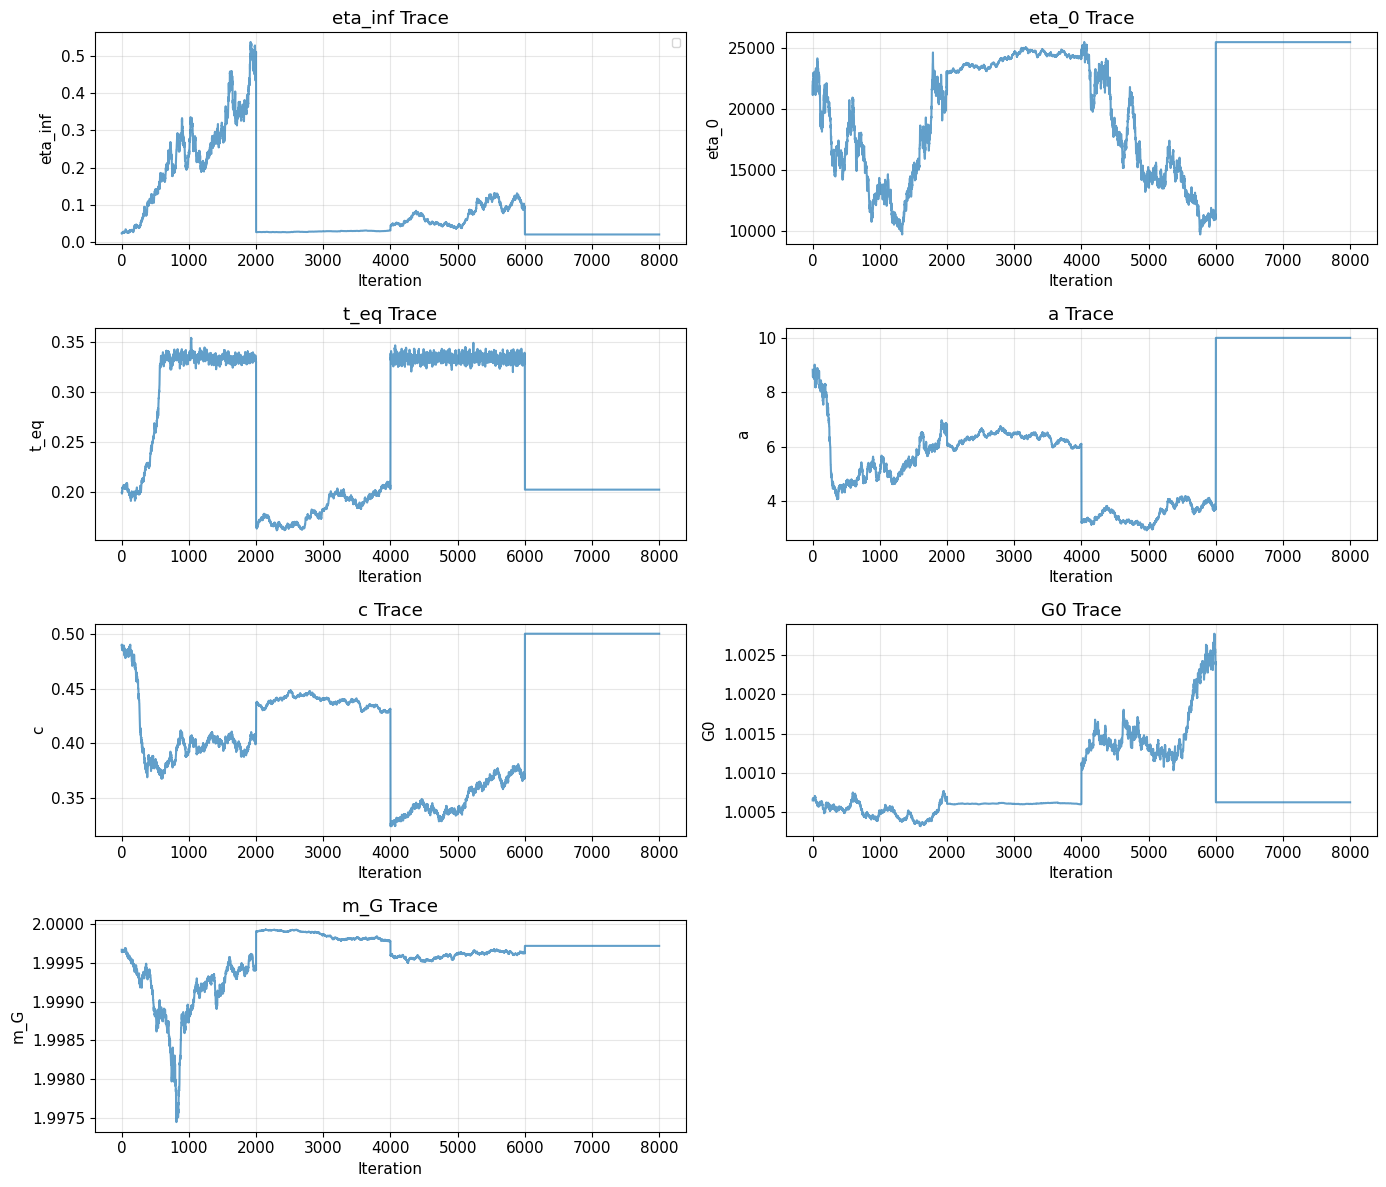

In [11]:
# Trace plots for convergence assessment
fig, axes = plt.subplots(4, 2, figsize=(14, 12))
axes = axes.flatten()

for idx, param_name in enumerate(param_names):
    if param_name in samples:
        param_samples = samples[param_name]
        # Flatten chains for plotting
        if param_samples.ndim == 2:  # (chains, samples)
            for chain in range(param_samples.shape[0]):
                axes[idx].plot(param_samples[chain, :], alpha=0.7, label=f'Chain {chain+1}')
        else:
            axes[idx].plot(param_samples, alpha=0.7)
        
        axes[idx].set_xlabel('Iteration')
        axes[idx].set_ylabel(param_name)
        axes[idx].set_title(f'{param_name} Trace')
        axes[idx].grid(True, alpha=0.3)
        if idx == 0:
            axes[idx].legend(fontsize=8)

# Hide extra subplot
if len(param_names) < len(axes):
    axes[-1].axis('off')

plt.tight_layout()
display(fig)
plt.close(fig)

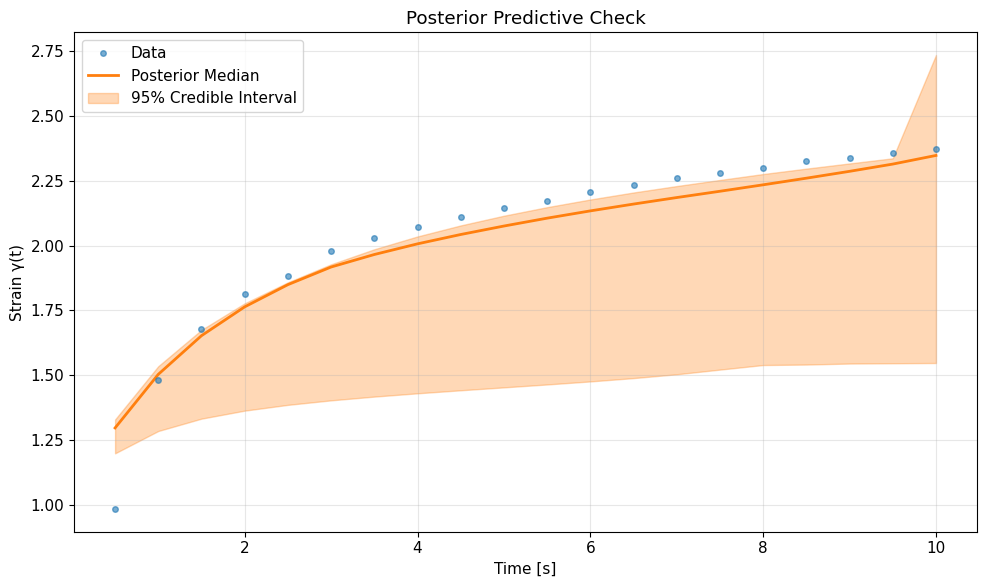

In [12]:
# Posterior predictive check
n_posterior_samples = 100
posterior_predictions = []

# Sample from posterior
for i in range(n_posterior_samples):
    # Random sample from flattened posterior
    idx = np.random.randint(0, samples[param_names[0]].size)
    
    # Get individual parameter values
    sample_eta_inf = float(samples['eta_inf'].flatten()[idx])
    sample_eta_0 = float(samples['eta_0'].flatten()[idx])
    sample_t_eq = float(samples['t_eq'].flatten()[idx])
    sample_a = float(samples['a'].flatten()[idx])
    sample_c = float(samples['c'].flatten()[idx])
    sample_G0 = float(samples['G0'].flatten()[idx])
    sample_m_G = float(samples['m_G'].flatten()[idx])
    
    # Predict using scipy-style wrapper
    gamma_pred_sample = dmt_creep_fn(
        time_data, sample_eta_inf, sample_eta_0, sample_t_eq, 
        sample_a, sample_c, sample_G0, sample_m_G
    )
    posterior_predictions.append(gamma_pred_sample)

posterior_predictions = jnp.array(posterior_predictions)

# Compute credible interval
lower_bound = jnp.percentile(posterior_predictions, 2.5, axis=0)
upper_bound = jnp.percentile(posterior_predictions, 97.5, axis=0)
median_pred = jnp.median(posterior_predictions, axis=0)

# Plot posterior predictive
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(time_data, gamma_data, 'o', markersize=4, alpha=0.6, label='Data', zorder=3)
ax.plot(time_data, median_pred, '-', linewidth=2, color='C1', label='Posterior Median', zorder=2)
ax.fill_between(time_data, lower_bound, upper_bound, alpha=0.3, color='C1', 
                 label='95% Credible Interval', zorder=1)

ax.set_xlabel('Time [s]')
ax.set_ylabel('Strain γ(t)')
ax.set_title('Posterior Predictive Check')
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
display(fig)
plt.close(fig)

## Physics: Viscosity Bifurcation Analysis

Now we explore how the DMT model predicts different behavior at different stress levels:

1. **Sub-yield regime**: Structure rebuilds faster than breakdown → bounded strain
2. **Critical regime**: Balance between rebuilding and breakdown → delayed yielding
3. **Supra-yield regime**: Breakdown dominates → unbounded flow

In [13]:
# Test multiple stress levels
stress_levels = jnp.array([0.5, 1.0, 5.0, 50.0])  # Pa
t_end = 500.0  # Extended time to see long-term behavior
dt=1.00

results = {}
for sigma in stress_levels:
    t, gamma, gamma_dot, lam = model.simulate_creep(
        sigma_0=float(sigma),
        t_end=t_end,
        dt=dt
    )
    results[float(sigma)] = {
        't': t,
        'gamma': gamma,
        'gamma_dot': gamma_dot,
        'lambda': lam
    }

print(f"Simulated creep at {len(stress_levels)} stress levels")
print(f"Stress range: {stress_levels[0]} - {stress_levels[-1]} Pa")

Simulated creep at 4 stress levels
Stress range: 0.5 - 50.0 Pa


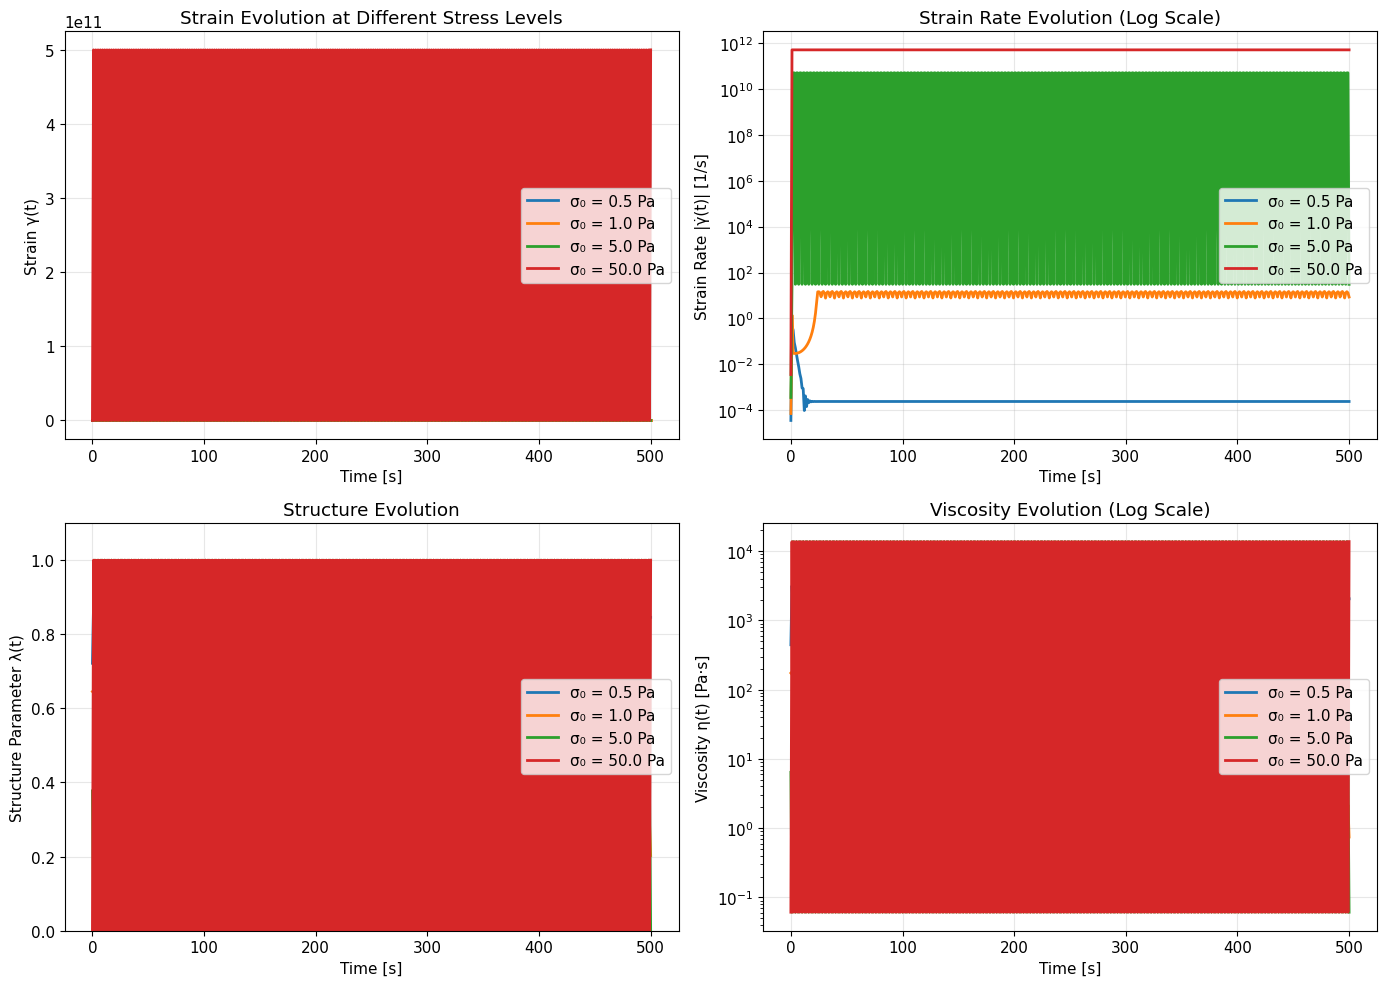

In [14]:
# Plot viscosity bifurcation
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Strain evolution
for sigma in stress_levels:
    data = results[float(sigma)]
    axes[0, 0].plot(data['t'], data['gamma'], linewidth=2, label=f'σ₀ = {sigma} Pa')

axes[0, 0].set_xlabel('Time [s]')
axes[0, 0].set_ylabel('Strain γ(t)')
axes[0, 0].set_title('Strain Evolution at Different Stress Levels')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()

# Strain rate evolution
for sigma in stress_levels:
    data = results[float(sigma)]
    axes[0, 1].semilogy(data['t'], jnp.abs(data['gamma_dot']), linewidth=2, label=f'σ₀ = {sigma} Pa')

axes[0, 1].set_xlabel('Time [s]')
axes[0, 1].set_ylabel('Strain Rate |γ̇(t)| [1/s]')
axes[0, 1].set_title('Strain Rate Evolution (Log Scale)')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend()

# Structure evolution
for sigma in stress_levels:
    data = results[float(sigma)]
    axes[1, 0].plot(data['t'], data['lambda'], linewidth=2, label=f'σ₀ = {sigma} Pa')

axes[1, 0].set_xlabel('Time [s]')
axes[1, 0].set_ylabel('Structure Parameter λ(t)')
axes[1, 0].set_title('Structure Evolution')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].legend()
axes[1, 0].set_ylim([0, 1.1])

# Viscosity evolution (η = η_∞ * (η_0/η_∞)^λ)
eta_inf = model.parameters["eta_inf"].value
eta_0 = model.parameters["eta_0"].value
for sigma in stress_levels:
    data = results[float(sigma)]
    eta = eta_inf * (eta_0 / eta_inf) ** data['lambda']
    axes[1, 1].semilogy(data['t'], eta, linewidth=2, label=f'σ₀ = {sigma} Pa')

axes[1, 1].set_xlabel('Time [s]')
axes[1, 1].set_ylabel('Viscosity η(t) [Pa·s]')
axes[1, 1].set_title('Viscosity Evolution (Log Scale)')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].legend()

plt.tight_layout()
display(fig)
plt.close(fig)

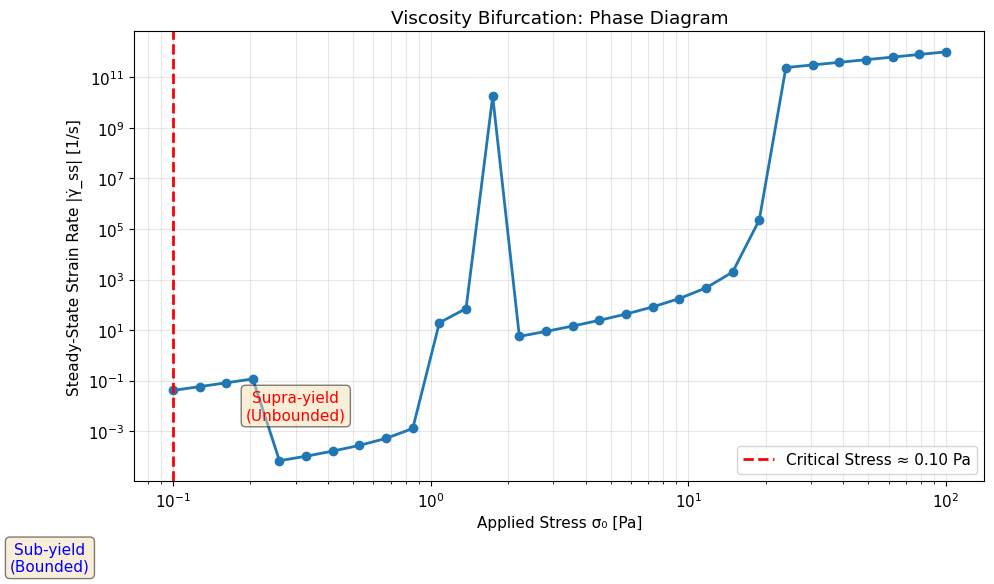


Estimated critical yield stress: σ_y ≈ 0.10 Pa


In [15]:
# Phase diagram: steady-state strain rate vs applied stress
# Identify critical yield stress

# Sample more stress levels for phase diagram
stress_scan = jnp.logspace(-1, 2, 30)  # 0.1 to 100 Pa
steady_state_rates = []

for sigma in stress_scan:
    t, gamma, gamma_dot, lam = model.simulate_creep(
        sigma_0=float(sigma),
        t_end=500.0,
        dt=1.0  # Use dt instead of n_points
    )
    # Take final strain rate as proxy for steady state
    steady_state_rates.append(float(jnp.abs(gamma_dot[-1])))

steady_state_rates = jnp.array(steady_state_rates)

# Find critical stress (where rate changes significantly)
# Use threshold: where steady rate > 1e-6 s^-1
yielding_mask = steady_state_rates > 1e-6
if jnp.any(yielding_mask):
    critical_stress_idx = jnp.where(yielding_mask)[0][0]
    critical_stress = stress_scan[critical_stress_idx]
else:
    critical_stress = None

# Plot phase diagram
fig, ax = plt.subplots(figsize=(10, 6))

ax.loglog(stress_scan, steady_state_rates, 'o-', linewidth=2, markersize=6)

if critical_stress is not None:
    ax.axvline(critical_stress, color='red', linestyle='--', linewidth=2, 
               label=f'Critical Stress ≈ {critical_stress:.2f} Pa')

ax.set_xlabel('Applied Stress σ₀ [Pa]')
ax.set_ylabel('Steady-State Strain Rate |γ̇_ss| [1/s]')
ax.set_title('Viscosity Bifurcation: Phase Diagram')
ax.grid(True, alpha=0.3, which='both')
ax.legend()

# Add annotations
if critical_stress is not None:
    ax.text(critical_stress / 3, 1e-8, 'Sub-yield\n(Bounded)', 
            ha='center', va='center', fontsize=11, color='blue',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    ax.text(critical_stress * 3, 1e-2, 'Supra-yield\n(Unbounded)', 
            ha='center', va='center', fontsize=11, color='red',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
display(fig)
plt.close(fig)

if critical_stress is not None:
    print(f"\nEstimated critical yield stress: σ_y ≈ {critical_stress:.2f} Pa")
else:
    print("\nNo clear yield stress identified in this stress range")

## Save Results

In [16]:
# Create output directory
output_dir = Path("../outputs/dmt/creep")
output_dir.mkdir(parents=True, exist_ok=True)

# Save NLSQ results
nlsq_output = output_dir / "mucus_creep_nlsq.txt"
with open(nlsq_output, 'w') as f:
    f.write("DMT Creep NLSQ Fitting Results\n")
    f.write("=" * 50 + "\n\n")
    f.write(f"Applied stress: {sigma_0} Pa\n")
    f.write(f"Data points: {len(time_data)}\n")
    f.write(f"R² score: {metrics['R2']:.6f}\n")
    f.write(f"RMSE: {metrics['RMSE']:.6e}\n\n")
    f.write("Fitted Parameters:\n")
    f.write("-" * 50 + "\n")
    for name, value in fitted_params.items():
        f.write(f"{name:12s}: {value:.6e}\n")

# Save Bayesian results
bayesian_output = output_dir / "mucus_creep_bayesian.txt"
with open(bayesian_output, 'w') as f:
    f.write("DMT Creep Bayesian Inference Results\n")
    f.write("=" * 50 + "\n\n")
    f.write("95% Credible Intervals:\n")
    f.write("-" * 50 + "\n")
    for param_name in param_names:
        if param_name in intervals:
            lower, upper = intervals[param_name]
            median = jnp.median(samples[param_name])
            f.write(f"{param_name:12s}: [{lower:.6e}, {upper:.6e}], median: {median:.6e}\n")

# Save bifurcation data
bifurcation_output = output_dir / "viscosity_bifurcation.csv"
bifurcation_data = np.column_stack([stress_scan, steady_state_rates])
np.savetxt(bifurcation_output, bifurcation_data, delimiter=',', 
           header='Stress[Pa],SteadyStateRate[1/s]', comments='')

print(f"Results saved to: {output_dir}")
print(f"  - NLSQ results: {nlsq_output.name}")
print(f"  - Bayesian results: {bayesian_output.name}")
print(f"  - Bifurcation data: {bifurcation_output.name}")

Results saved to: ../outputs/dmt/creep
  - NLSQ results: mucus_creep_nlsq.txt
  - Bayesian results: mucus_creep_bayesian.txt
  - Bifurcation data: viscosity_bifurcation.csv


## Key Takeaways

### Maxwell Creep Mechanics

1. **Elastic Jump**: Instantaneous response γ_e(0) = σ₀/G captures elastic storage
2. **Viscous Flow**: Time-dependent flow γ̇_v = σ₀/η(λ) driven by structure-dependent viscosity
3. **Structure Coupling**: Viscous flow rate feeds back to structure evolution

### Viscosity Bifurcation

1. **Sub-yield** (σ₀ < σ_y): Aging dominates → λ increases → η increases → flow stops
2. **Supra-yield** (σ₀ > σ_y): Rejuvenation dominates → λ decreases → η decreases → continuous flow
3. **Critical Stress**: Marks transition between bounded and unbounded creep

### Delayed Yielding

1. **Near σ_y**: Structure evolution timescale t_eq controls delay to steady state
2. **Biological Relevance**: Mucus under gravity vs applied pressure shows threshold behavior
3. **Thixotropic Signature**: Time-dependent yield transition characteristic of soft materials

### Practical Implications

- **Material Design**: Control t_eq, a, c to tune yielding behavior
- **Processing**: Apply stress above σ_y for continuous flow
- **Quality Control**: Measure creep compliance to infer yield stress and structure timescales